In [ ]:
# RUL 생성
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1. 데이터 불러오기
train = pd.read_csv('train_FD001.txt', sep='\s+', header=None)
test = pd.read_csv('test_FD001.txt', sep='\s+', header=None)
rul = pd.read_csv('RUL_FD001.txt', sep='\s+', header=None)

# 2. 컬럼명 지정
columns = ['id', 'cycle'] + ['op1', 'op2', 'op3'] + [f'sensor{i}' for i in range(1, 22)]
train.columns = test.columns = columns
rul.columns = ['RUL']

# train: RUL 계산
rul_train = train.groupby('id')['cycle'].max().reset_index()
rul_train.columns = ['id', 'max']
train = train.merge(rul_train, on='id', how='left')
train['RUL'] = train['max'] - train['cycle']
train.drop(columns='max', inplace=True)

# test: RUL 계산 (rul + test cycle 정보 결합)
rul['id'] = rul.index + 1
last_cycle = test.groupby('id')['cycle'].max().reset_index()
last_cycle.columns = ['id', 'last_cycle']
rul = rul.merge(last_cycle, on='id')
rul['rul_failed'] = rul['RUL'] + rul['last_cycle']
test = test.merge(rul[['id', 'rul_failed']], on='id', how='left')
test['RUL'] = test['rul_failed'] - test['cycle']
test.drop(columns='rul_failed', inplace=True)


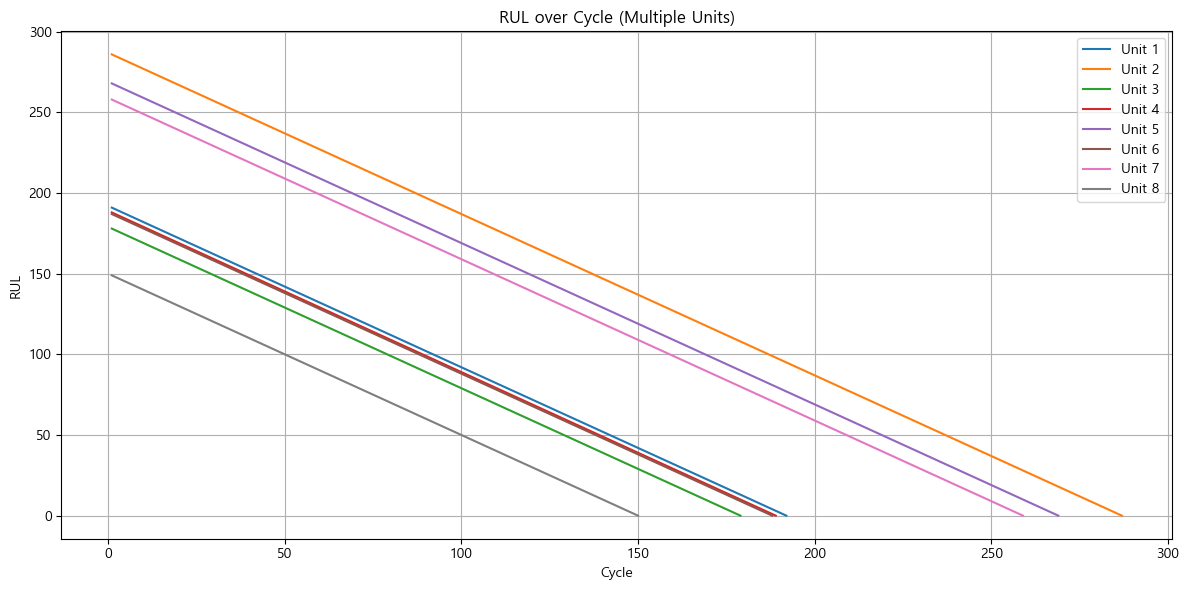

In [82]:
plt.figure(figsize=(12, 6))
for uid in train['id'].unique()[:8]:
    data = train[train['id'] == uid]
    plt.plot(data['cycle'], data['RUL'], label=f'Unit {uid}')
plt.title('RUL over Cycle (Multiple Units)')
plt.xlabel('Cycle')
plt.ylabel('RUL')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


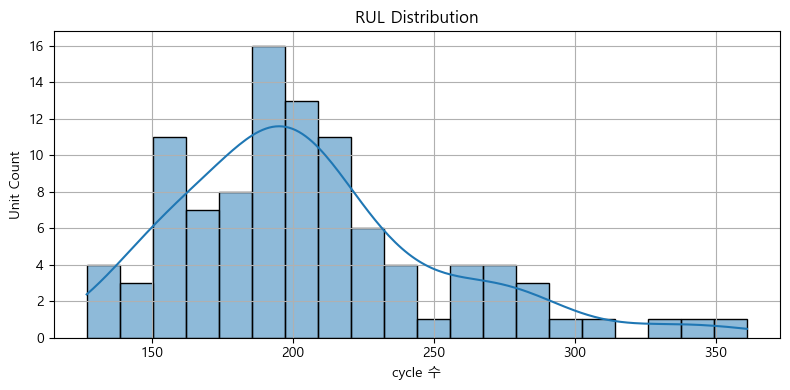

In [86]:
initial_rul = train.groupby('id')['RUL'].max().reset_index()

plt.figure(figsize=(8, 4))
sns.histplot(initial_rul['RUL'], bins=20, kde=True)
plt.title('RUL Distribution')
plt.xlabel('cycle 수')
plt.ylabel('Unit Count')
plt.grid(True)
plt.tight_layout()
plt.show()


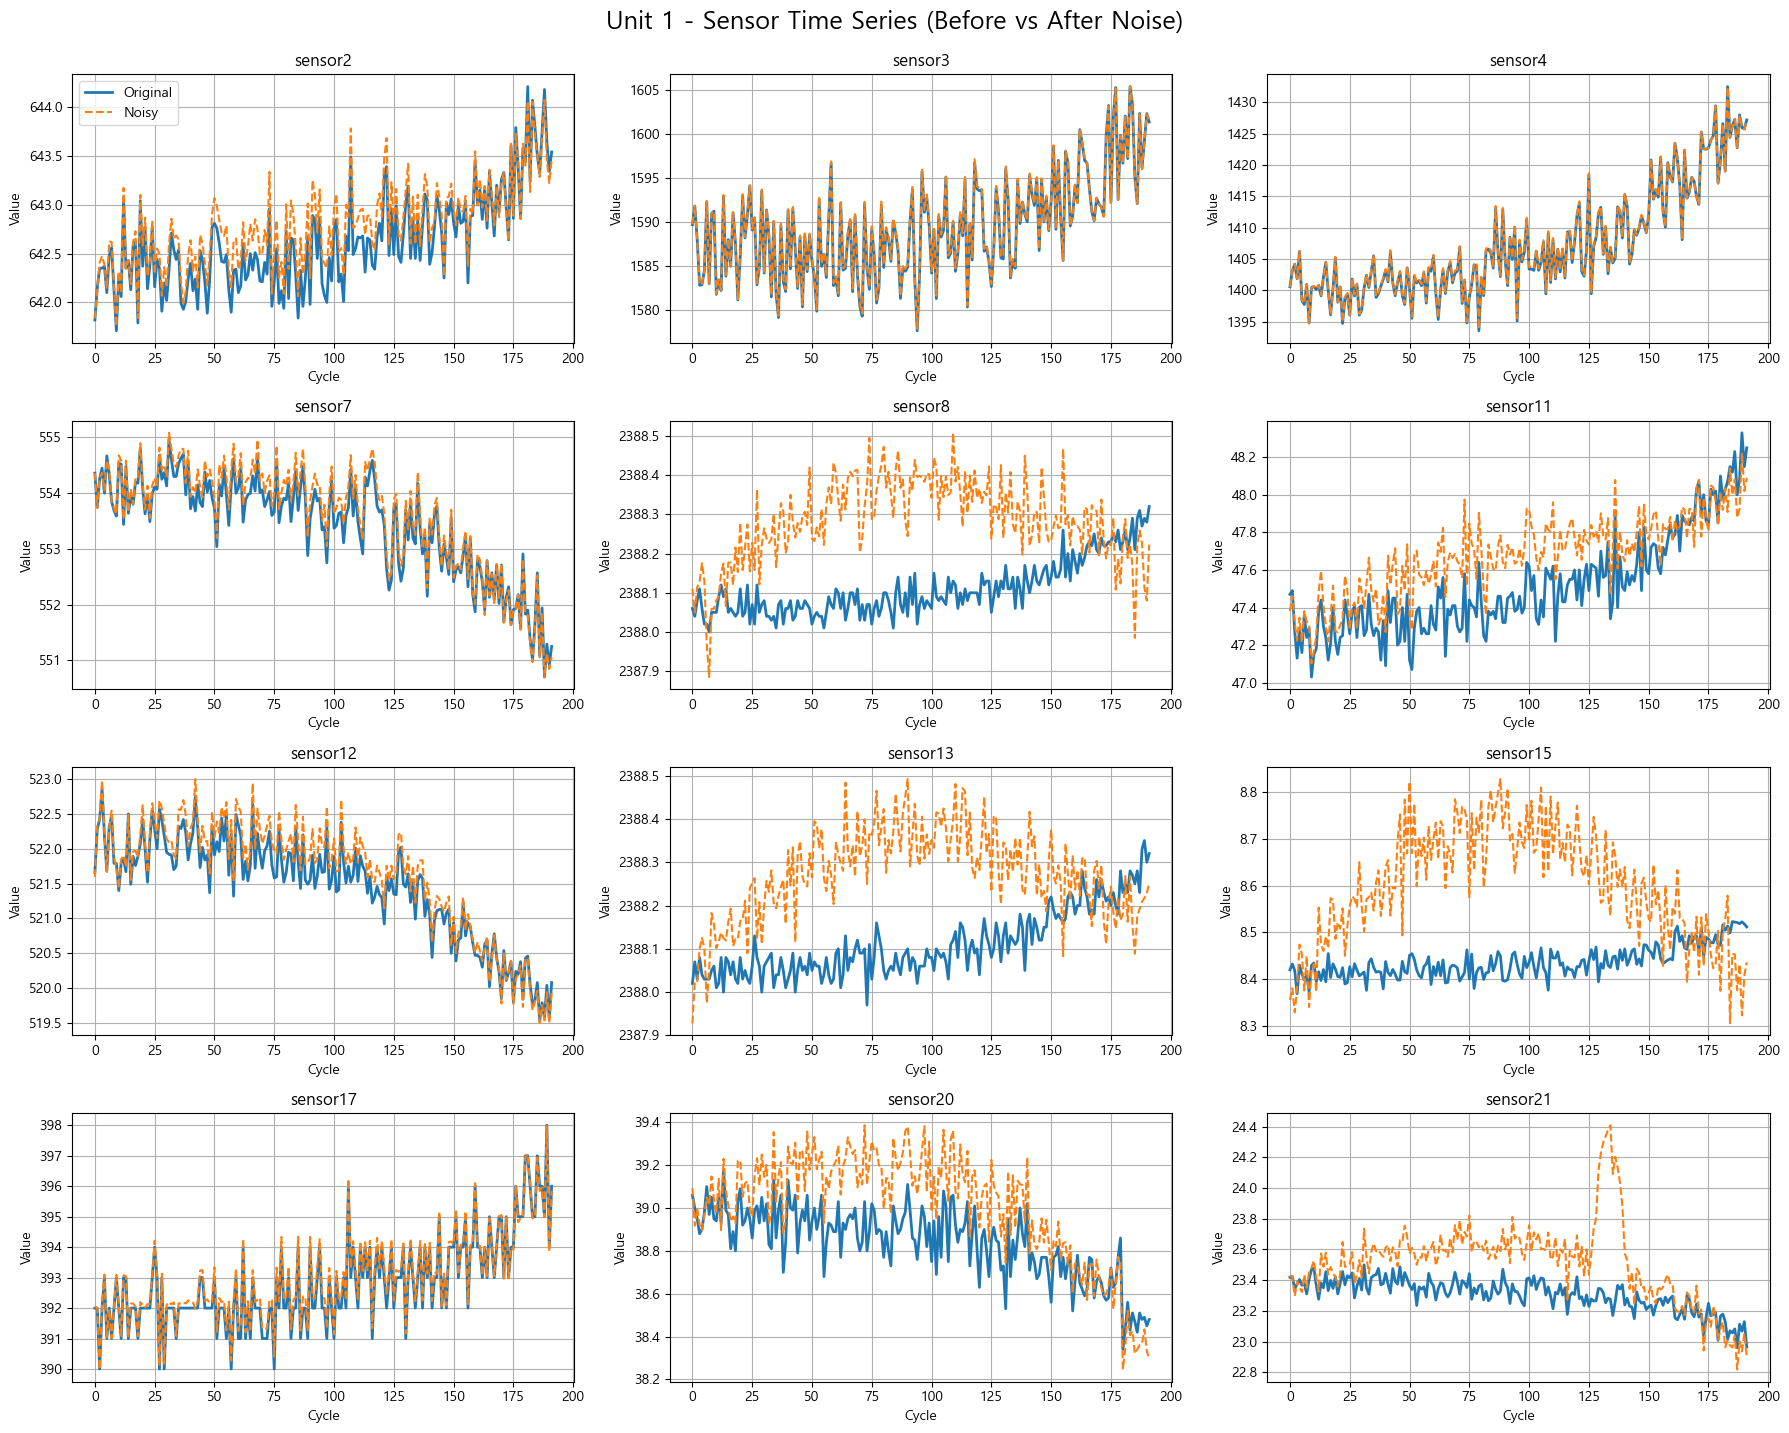

In [ ]:
#노이즈 추가 전후 비교
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from noise_input import RealisticNoiseInjector  # 사용자 정의 노이즈 클래스

# 1. 데이터 불러오기
train = pd.read_csv('train_FD001.txt', sep='\s+', header=None)
columns = ['id', 'cycle'] + ['op1', 'op2', 'op3'] + [f'sensor{i}' for i in range(1, 22)]
train.columns = columns

# 2. 피처 선택
sensor_features = ['sensor2', 'sensor3', 'sensor4', 'sensor7', 'sensor8',
                   'sensor11', 'sensor12', 'sensor13', 'sensor15', 'sensor17',
                   'sensor20', 'sensor21']  # 그래프는 이 센서들만
op_features = ['op1', 'op2', 'op3']         # 노이즈는 적용 안 함

# 3. 노이즈 주입 (sensor만)
noise_injector = RealisticNoiseInjector(seed=42)
X_original = train[sensor_features].copy().astype(float)
X_noisy = X_original.apply(lambda col: noise_injector.inject(col.values), axis=0)

# 4. 유닛 및 cycle 정보 추가
X_original['id'] = train['id'].values
X_original['cycle'] = train['cycle'].values
X_noisy['id'] = train['id'].values
X_noisy['cycle'] = train['cycle'].values

# 5. 시계열 시각화 (운영 변수는 제외)
unit_id = 1
n_sensors = len(sensor_features)
n_cols = 3
n_rows = (n_sensors + n_cols - 1) // n_cols

plt.figure(figsize=(n_cols * 6, n_rows * 3.5))

for i, sensor in enumerate(sensor_features): 
    original = X_original[X_original['id'] == unit_id].reset_index(drop=True)[sensor].values
    noisy = X_noisy[X_noisy['id'] == unit_id].reset_index(drop=True)[sensor].values

    plt.subplot(n_rows, n_cols, i + 1)
    plt.plot(original, label='Original', linewidth=2)
    plt.plot(noisy, label='Noisy', linestyle='--')
    plt.title(sensor)
    plt.xlabel("Cycle")
    plt.ylabel("Value")
    plt.grid(True)
    if i == 0:
        plt.legend()

plt.tight_layout()
plt.suptitle(f"Unit {unit_id} - Sensor Time Series (Before vs After Noise)", fontsize=18, y=1.02)
plt.show()


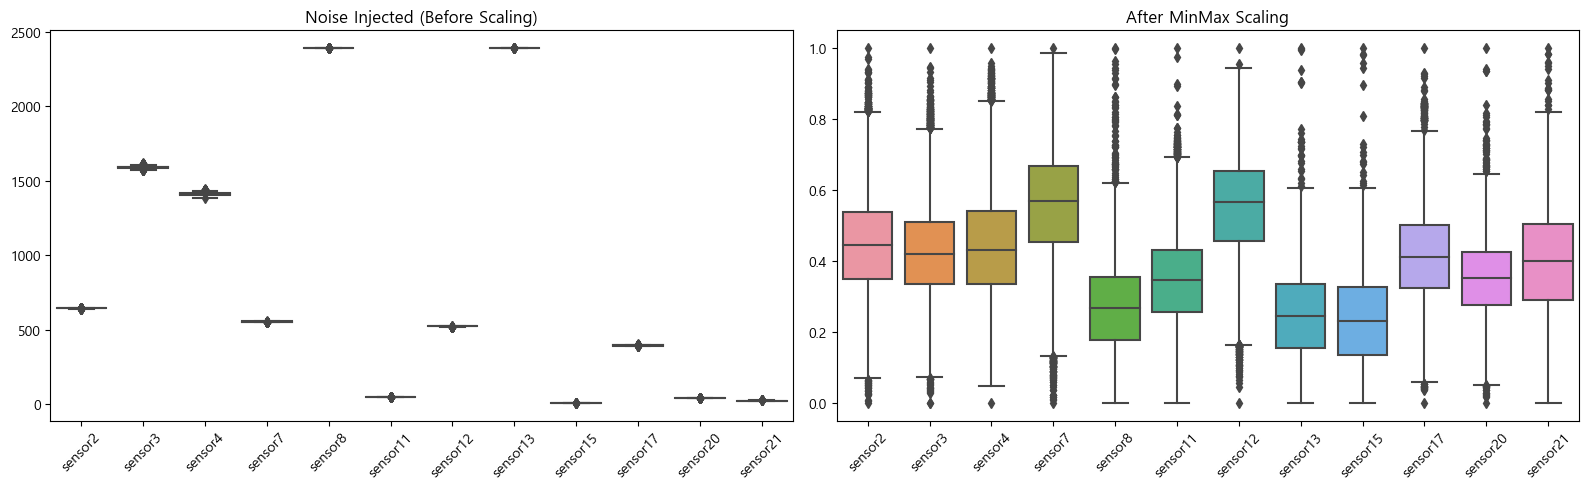

In [79]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from noise_input import RealisticNoiseInjector  # 사용자 정의 노이즈 클래스

# 1. 데이터 불러오기
train = pd.read_csv('train_FD001.txt', sep='\s+', header=None)
columns = ['id', 'cycle'] + ['op1', 'op2', 'op3'] + [f'sensor{i}' for i in range(1, 22)]
train.columns = columns

# 2. 피처 선택
sensor_features = ['sensor2', 'sensor3', 'sensor4', 'sensor7', 'sensor8',
                   'sensor11', 'sensor12', 'sensor13', 'sensor15', 'sensor17',
                   'sensor20', 'sensor21']

# 3. 노이즈 삽입 (센서에만)
noise_injector = RealisticNoiseInjector(seed=42)
X_noisy = train[sensor_features].copy().astype(float)
X_noisy = X_noisy.apply(lambda col: noise_injector.inject(col.values), axis=0)

# 4. 정규화 (MinMaxScaler)
scaler = MinMaxScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X_noisy), columns=sensor_features)

# 5. Boxplot 시각화 비교
plt.figure(figsize=(16, 5))

# 5-1. 노이즈 삽입 후 Boxplot
plt.subplot(1, 2, 1)
sns.boxplot(data=X_noisy)
plt.title("Noise Injected (Before Scaling)")
plt.xticks(rotation=45)

# 5-2. 정규화 후 Boxplot
plt.subplot(1, 2, 2)
sns.boxplot(data=X_scaled)
plt.title("After MinMax Scaling")
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


In [3]:
#단일 LSTM
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# 1. 데이터 불러오기
train = pd.read_csv('train_FD001.txt', sep='\s+', header=None)
test = pd.read_csv('test_FD001.txt', sep='\s+', header=None)
rul = pd.read_csv('RUL_FD001.txt', sep='\s+', header=None)

columns = ['id', 'cycle'] + ['op1', 'op2', 'op3'] + [f'sensor{i}' for i in range(1, 22)]
train.columns = test.columns = columns
rul.columns = ['RUL']

# 2. RUL 생성
rul_train = train.groupby('id')['cycle'].max().reset_index()
rul_train.columns = ['id', 'max']
train = train.merge(rul_train, on='id', how='left')
train['RUL'] = train['max'] - train['cycle']
train.drop(columns='max', inplace=True)

rul['id'] = rul.index + 1
last_cycle = test.groupby('id')['cycle'].max().reset_index()
last_cycle.columns = ['id', 'last_cycle']
rul = rul.merge(last_cycle, on='id')
rul['rul_failed'] = rul['RUL'] + rul['last_cycle']
test = test.merge(rul[['id', 'rul_failed']], on='id', how='left')
test['RUL'] = test['rul_failed'] - test['cycle']
test.drop(columns='rul_failed', inplace=True)

# 3. 센서 선택 (표준편차 낮은 센서 제거)
low_variance_sensors = ['sensor1', 'sensor5', 'sensor6', 'sensor8', 'sensor10',
                        'sensor11', 'sensor13', 'sensor15', 'sensor16', 'sensor18',
                        'sensor19', 'sensor20', 'sensor21']
selected_features = [s for s in train.columns if s.startswith('sensor') and s not in low_variance_sensors]
feature_cols = selected_features + ['op1', 'op2', 'op3']

# 4. 노이즈 추가 → 정규화
noise = np.random.normal(0, 0.05, size=train[feature_cols].shape)
train_noisy = train.copy()
train_noisy[feature_cols] += noise

scaler = MinMaxScaler()
train_scaled = train_noisy.copy()
test_scaled = test.copy()
train_scaled[feature_cols] = scaler.fit_transform(train_noisy[feature_cols])
test_scaled[feature_cols] = scaler.transform(test[feature_cols])

# 5. 시퀀스 생성
def create_sequences(df, seq_len, feature_cols, target_col):
    X, y = [], []
    for _, group in df.groupby('id'):
        group = group.reset_index(drop=True)
        for i in range(len(group) - seq_len):
            seq_x = group.loc[i:i+seq_len-1, feature_cols].values
            seq_y = group.loc[i+seq_len, target_col]
            X.append(seq_x)
            y.append(seq_y)
    return np.array(X), np.array(y)

sequence_length = 30
target_col = 'RUL'

X_train, y_train = create_sequences(train_scaled, sequence_length, feature_cols, target_col)
X_test, y_test = create_sequences(test_scaled, sequence_length, feature_cols, target_col)

# 6. 단일 LSTM 모델 정의
model = Sequential()
model.add(LSTM(100, input_shape=(sequence_length, len(feature_cols))))
model.add(Dense(100, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mse')
model.summary()

# 7. 학습
early_stop = EarlyStopping(patience=5, restore_best_weights=True)
model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, callbacks=[early_stop])

# 8. 평가
y_pred = model.predict(X_test).flatten()
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae:.2f}, RMSE: {rmse:.2f}, R²: {r2:.4f}")


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 100)               44800     
                                                                 
 dense_4 (Dense)             (None, 100)               10100     
                                                                 
 dropout_2 (Dropout)         (None, 100)               0         
                                                                 
 dense_5 (Dense)             (None, 1)                 101       
                                                                 
Total params: 55001 (214.85 KB)
Trainable params: 55001 (214.85 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/50
441/441 [==============================] - 14s 27ms/step - loss: 4137.0547 - val_loss: 5476.2559
Epoch 2/50
441/441 [====================

## LSTM

In [5]:
#변수선택 
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from scipy.stats import zscore

# 1. 데이터 불러오기
train = pd.read_csv('train_FD001.txt', sep='\s+', header=None)
test = pd.read_csv('test_FD001.txt', sep='\s+', header=None)
rul = pd.read_csv('RUL_FD001.txt', sep='\s+', header=None)

columns = ['id', 'cycle'] + ['op1', 'op2', 'op3'] + [f'sensor{i}' for i in range(1, 22)]
train.columns = test.columns = columns
rul.columns = ['RUL']

# 2. RUL 생성 (상한선 적용)
rul_train = train.groupby('id')['cycle'].max().reset_index()
rul_train.columns = ['id', 'max']
train = train.merge(rul_train, on='id', how='left')
train['RUL'] = train['max'] - train['cycle']
train['RUL'] = np.minimum(train['RUL'], 125)  # RUL 상한선 적용
train.drop(columns='max', inplace=True)

rul['id'] = rul.index + 1
last_cycle = test.groupby('id')['cycle'].max().reset_index()
last_cycle.columns = ['id', 'last_cycle']
rul = rul.merge(last_cycle, on='id')
rul['rul_failed'] = rul['RUL'] + rul['last_cycle']
test = test.merge(rul[['id', 'rul_failed']], on='id', how='left')
test['RUL'] = test['rul_failed'] - test['cycle']
test['RUL'] = np.minimum(test['RUL'], 125)  # 테스트도 상한선 적용
test.drop(columns='rul_failed', inplace=True)

# 3. 이상치 제거 (완화된 Z-score 방식)
sensor_cols = [col for col in train.columns if col.startswith('sensor')]
z_scores = np.abs(train[sensor_cols].apply(zscore))
row_outlier_ratio = (z_scores > 3).sum(axis=1) / len(sensor_cols)
train = train[row_outlier_ratio < 0.5].reset_index(drop=True)  # 50% 이상 이상치인 행 제거

# 4. 중요도 기반 센서 선택 (랜덤 포레스트)
X_temp = train[sensor_cols + ['op1', 'op2', 'op3']]
y_temp = train['RUL']

rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_temp, y_temp)

feature_importances = pd.Series(rf.feature_importances_, index=X_temp.columns)
selected_features = feature_importances.sort_values(ascending=False).head(12).index.tolist()  # 상위 12개

print("선택된 중요 센서 및 운영 변수:", selected_features)

# 5. 정규화
scaler = MinMaxScaler()
train_scaled = train.copy()
test_scaled = test.copy()
train_scaled[selected_features] = scaler.fit_transform(train[selected_features])
test_scaled[selected_features] = scaler.transform(test[selected_features])


선택된 중요 센서 및 운영 변수: ['sensor11', 'sensor9', 'sensor4', 'sensor12', 'sensor7', 'sensor14', 'sensor15', 'sensor21', 'sensor2', 'sensor3', 'sensor13', 'sensor20']


In [18]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from scipy.stats import zscore

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# 1. 데이터 불러오기
train = pd.read_csv('train_FD001.txt', sep='\s+', header=None)
test = pd.read_csv('test_FD001.txt', sep='\s+', header=None)
rul = pd.read_csv('RUL_FD001.txt', sep='\s+', header=None)

columns = ['id', 'cycle'] + ['op1', 'op2', 'op3'] + [f'sensor{i}' for i in range(1, 22)]
train.columns = test.columns = columns
rul.columns = ['RUL']

# 2. RUL 생성 + 상한선 125 적용
rul_train = train.groupby('id')['cycle'].max().reset_index()
rul_train.columns = ['id', 'max']
train = train.merge(rul_train, on='id', how='left')
train['RUL'] = np.minimum(train['max'] - train['cycle'], 125)
train.drop(columns='max', inplace=True)

rul['id'] = rul.index + 1
last_cycle = test.groupby('id')['cycle'].max().reset_index()
last_cycle.columns = ['id', 'last_cycle']
rul = rul.merge(last_cycle, on='id')
rul['rul_failed'] = rul['RUL'] + rul['last_cycle']
test = test.merge(rul[['id', 'rul_failed']], on='id', how='left')
test['RUL'] = np.minimum(test['rul_failed'] - test['cycle'], 125)
test.drop(columns='rul_failed', inplace=True)

# 3. 이상치 제거
sensor_cols = [col for col in train.columns if col.startswith('sensor')]
z_scores = np.abs(train[sensor_cols].apply(zscore))
row_outlier_ratio = (z_scores > 3).sum(axis=1) / len(sensor_cols)
train = train[row_outlier_ratio < 0.5].reset_index(drop=True)

# 4. 중요 센서 선택 (RandomForest 기반)
X_temp = train[sensor_cols + ['op1', 'op2', 'op3']]
y_temp = train['RUL']
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_temp, y_temp)
feature_importances = pd.Series(rf.feature_importances_, index=X_temp.columns)
selected_features = feature_importances.sort_values(ascending=False).head(12).index.tolist()

for op in ['op1', 'op2', 'op3']:
    if op not in selected_features:
        selected_features.append(op)

# 5. 정규화
scaler = MinMaxScaler()
train_scaled = train.copy()
test_scaled = test.copy()
train_scaled[selected_features] = scaler.fit_transform(train[selected_features])
test_scaled[selected_features] = scaler.transform(test[selected_features])

# 6. 시계열 시퀀스 생성
def create_sequences(df, seq_len, feature_cols, target_col):
    X, y = [], []
    for _, group in df.groupby('id'):
        group = group.reset_index(drop=True)
        for i in range(len(group) - seq_len):
            seq_x = group.loc[i:i+seq_len-1, feature_cols].values
            seq_y = group.loc[i+seq_len, target_col]
            X.append(seq_x)
            y.append(seq_y)
    return np.array(X), np.array(y)

def create_last_sequences(df, seq_len, feature_cols, target_col):
    X, y = [], []
    for _, group in df.groupby('id'):
        group = group.reset_index(drop=True)
        if len(group) >= seq_len:
            seq_x = group.iloc[-seq_len:][feature_cols].values
            seq_y = group.iloc[-1][target_col]
            X.append(seq_x)
            y.append(seq_y)
    return np.array(X), np.array(y)

sequence_length = 30
target_col = 'RUL'
feature_cols = selected_features

X_train, y_train = create_sequences(train_scaled, sequence_length, feature_cols, target_col)
X_test, y_test = create_last_sequences(test_scaled, sequence_length, feature_cols, target_col)

print(" 학습 샘플 수:", len(X_train), "테스트 샘플 수:", len(X_test))

# 7. 단일 LSTM 모델
model = Sequential()
model.add(LSTM(100, input_shape=(sequence_length, len(feature_cols))))
model.add(Dense(100, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mse')
model.summary()

# 8. 학습
early_stop = EarlyStopping(patience=5, restore_best_weights=True)
history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stop]
)

# 9. 평가
y_pred = model.predict(X_test).flatten()
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f" [LSTM] MAE: {mae:.2f}, RMSE: {rmse:.2f}, R²: {r2:.4f}")


 학습 샘플 수: 17631 테스트 샘플 수: 100
Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 100)               46400     
                                                                 
 dense_12 (Dense)            (None, 100)               10100     
                                                                 
 dropout_6 (Dropout)         (None, 100)               0         
                                                                 
 dense_13 (Dense)            (None, 1)                 101       
                                                                 
Total params: 56601 (221.10 KB)
Trainable params: 56601 (221.10 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/50
441/441 [==============================] - 11s 19ms/step - loss: 2297.6760 - val_loss: 1759.3829
Epoch 2/50

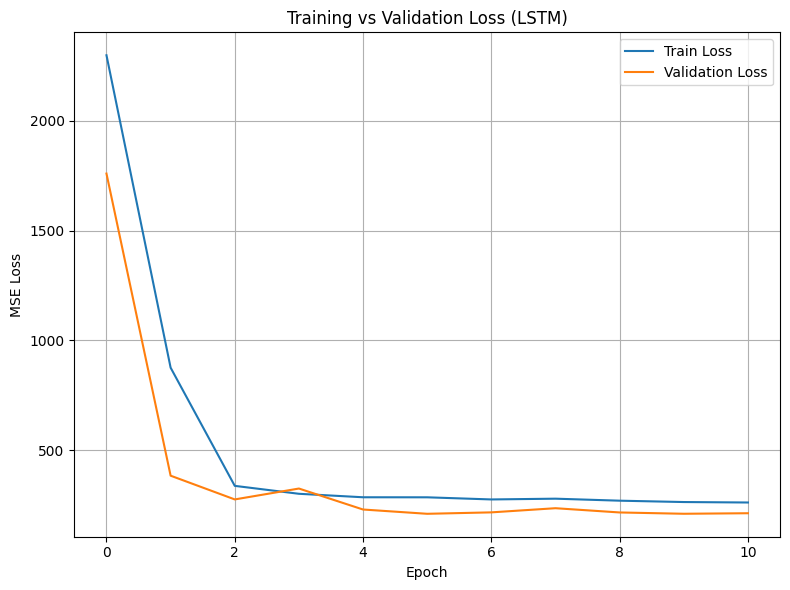

In [19]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("Training vs Validation Loss (LSTM)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("lstm_loss_curve.png")
plt.show()


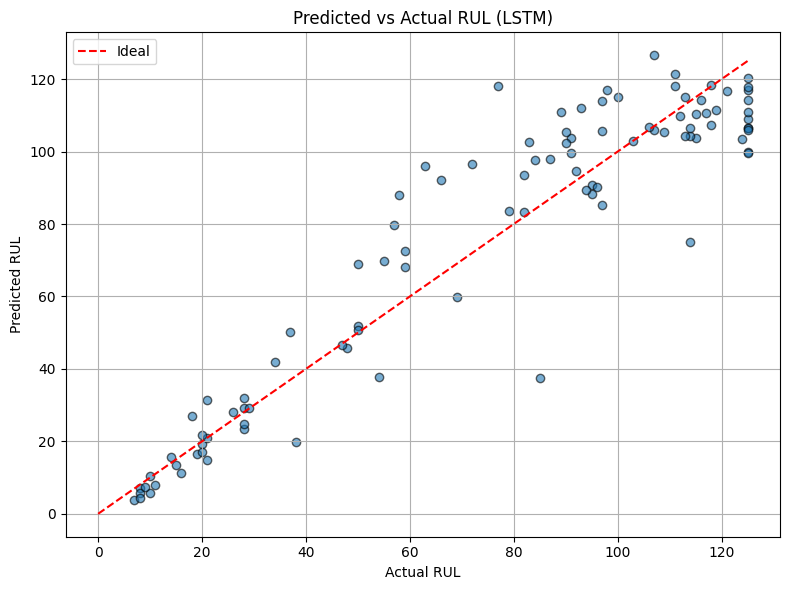

In [20]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.6, edgecolors='k')
plt.plot([0, max(y_test)], [0, max(y_test)], 'r--', label='Ideal')
plt.xlabel("Actual RUL")
plt.ylabel("Predicted RUL")
plt.title("Predicted vs Actual RUL (LSTM)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("lstm_pred_vs_actual.png")
plt.show()


In [21]:
# 모델 저장
model.save("lstm_rul_model.h5")
print("✅ 모델 저장 완료: lstm_rul_model.h5")


✅ 모델 저장 완료: lstm_rul_model.h5


c:\Users\eehfv\anaconda3\envs\br2\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## Bi-LSTM

In [11]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from scipy.stats import zscore

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Bidirectional, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# 1. 데이터 불러오기
train = pd.read_csv('train_FD001.txt', sep='\s+', header=None)
test = pd.read_csv('test_FD001.txt', sep='\s+', header=None)
rul = pd.read_csv('RUL_FD001.txt', sep='\s+', header=None)

columns = ['id', 'cycle'] + ['op1', 'op2', 'op3'] + [f'sensor{i}' for i in range(1, 22)]
train.columns = test.columns = columns
rul.columns = ['RUL']

# 2. RUL 생성 + 상한선 125 적용
rul_train = train.groupby('id')['cycle'].max().reset_index()
rul_train.columns = ['id', 'max']
train = train.merge(rul_train, on='id', how='left')
train['RUL'] = np.minimum(train['max'] - train['cycle'], 125)
train.drop(columns='max', inplace=True)

rul['id'] = rul.index + 1
last_cycle = test.groupby('id')['cycle'].max().reset_index()
last_cycle.columns = ['id', 'last_cycle']
rul = rul.merge(last_cycle, on='id')
rul['rul_failed'] = rul['RUL'] + rul['last_cycle']
test = test.merge(rul[['id', 'rul_failed']], on='id', how='left')
test['RUL'] = np.minimum(test['rul_failed'] - test['cycle'], 125)
test.drop(columns='rul_failed', inplace=True)

# 3. 이상치 제거 (센서 기준, 완화된 조건)
sensor_cols = [col for col in train.columns if col.startswith('sensor')]
z_scores = np.abs(train[sensor_cols].apply(zscore))
row_outlier_ratio = (z_scores > 3).sum(axis=1) / len(sensor_cols)
train = train[row_outlier_ratio < 0.5].reset_index(drop=True)

# 4. 중요 센서 선택 (RandomForest 기반)
X_temp = train[sensor_cols + ['op1', 'op2', 'op3']]
y_temp = train['RUL']
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_temp, y_temp)
feature_importances = pd.Series(rf.feature_importances_, index=X_temp.columns)
selected_features = feature_importances.sort_values(ascending=False).head(12).index.tolist()
print("✅ 선택된 중요 센서 및 운영 변수:", selected_features)

# 운영변수 빠져있으면 추가
for op in ['op1', 'op2', 'op3']:
    if op not in selected_features:
        selected_features.append(op)

# 5. 정규화
scaler = MinMaxScaler()
train_scaled = train.copy()
test_scaled = test.copy()
train_scaled[selected_features] = scaler.fit_transform(train[selected_features])
test_scaled[selected_features] = scaler.transform(test[selected_features])

# 6. 시계열 시퀀스 생성 함수
def create_sequences(df, seq_len, feature_cols, target_col):
    X, y = [], []
    for _, group in df.groupby('id'):
        group = group.reset_index(drop=True)
        for i in range(len(group) - seq_len):
            seq_x = group.loc[i:i+seq_len-1, feature_cols].values
            seq_y = group.loc[i+seq_len, target_col]
            X.append(seq_x)
            y.append(seq_y)
    return np.array(X), np.array(y)

def create_last_sequences(df, seq_len, feature_cols, target_col):
    X, y = [], []
    for _, group in df.groupby('id'):
        group = group.reset_index(drop=True)
        if len(group) >= seq_len:
            seq_x = group.iloc[-seq_len:][feature_cols].values
            seq_y = group.iloc[-1][target_col]
            X.append(seq_x)
            y.append(seq_y)
    return np.array(X), np.array(y)

# 7. 시퀀스 생성
sequence_length = 30
target_col = 'RUL'
feature_cols = selected_features

X_train, y_train = create_sequences(train_scaled, sequence_length, feature_cols, target_col)
X_test, y_test = create_last_sequences(test_scaled, sequence_length, feature_cols, target_col)

print("✅ 학습 샘플 수:", len(X_train), "테스트 샘플 수:", len(X_test))

# 8. Bi-LSTM 모델 정의
model = Sequential()
model.add(Bidirectional(LSTM(100, return_sequences=False), input_shape=(sequence_length, len(feature_cols))))
model.add(Dense(100, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mse')
model.summary()

# 9. 학습 (history 저장)
early_stop = EarlyStopping(patience=5, restore_best_weights=True)
history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stop]
)

# 10. 평가
y_pred = model.predict(X_test).flatten()
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae:.2f}, RMSE: {rmse:.2f}, R²: {r2:.4f}")



✅ 선택된 중요 센서 및 운영 변수: ['sensor11', 'sensor9', 'sensor4', 'sensor12', 'sensor7', 'sensor14', 'sensor15', 'sensor21', 'sensor2', 'sensor3', 'sensor13', 'sensor20']
✅ 학습 샘플 수: 17631 테스트 샘플 수: 100
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_1 (Bidirecti  (None, 200)               92800     
 onal)                                                           
                                                                 
 dense_8 (Dense)             (None, 100)               20100     
                                                                 
 dropout_4 (Dropout)         (None, 100)               0         
                                                                 
 dense_9 (Dense)             (None, 1)                 101       
                                                                 
Total params: 113001 (441.41 KB)
Trainable params: 113001 (4

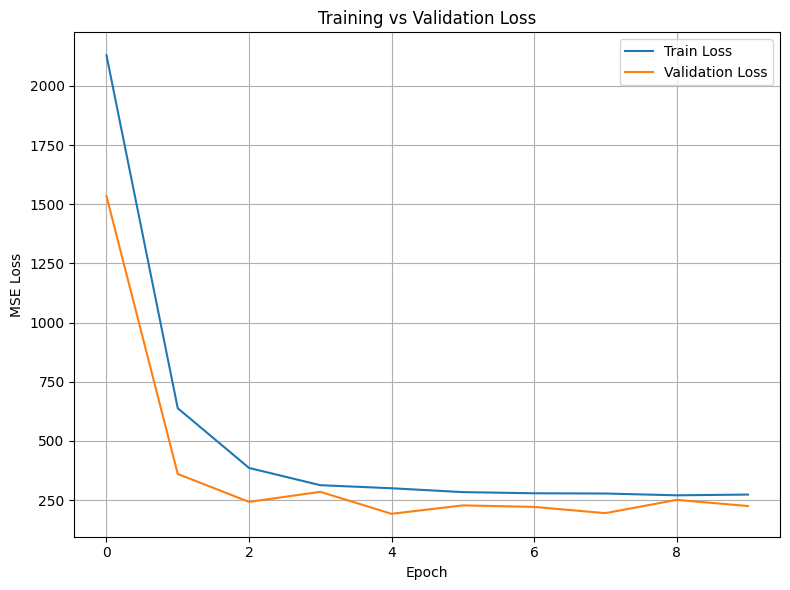

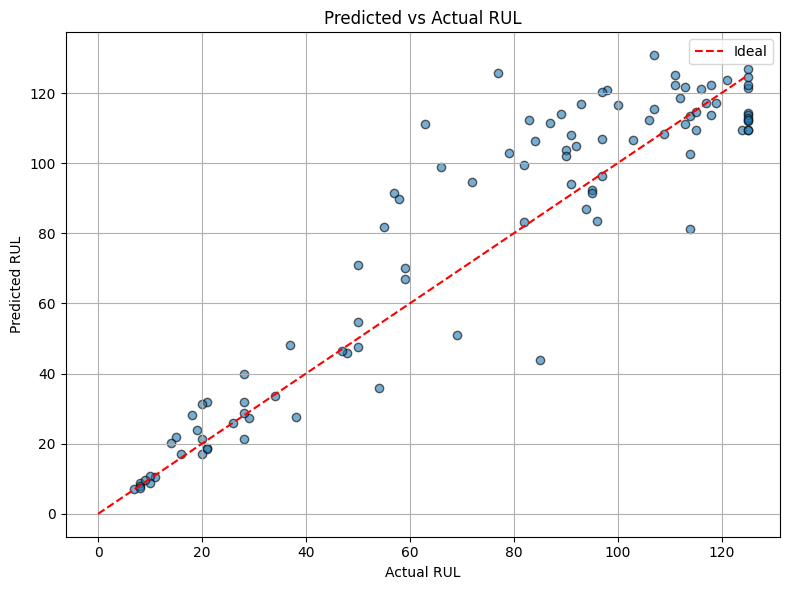

In [12]:
import matplotlib.pyplot as plt

# 1. 학습 손실 곡선
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("loss_curve.png")
plt.show()

#  2. 예측 vs 실제 RUL
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.6, edgecolors='k')
plt.plot([0, max(y_test)], [0, max(y_test)], 'r--', label='Ideal')
plt.xlabel("Actual RUL")
plt.ylabel("Predicted RUL")
plt.title("Predicted vs Actual RUL")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig("pred_vs_actual.png")
plt.show()


In [13]:
# 모델 저장 (.h5)
model.save("bilstm_rul_model.h5")
print("모델 저장 완료: bilstm_rul_model.h5")

모델 저장 완료: bilstm_rul_model.h5


c:\Users\eehfv\anaconda3\envs\br2\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## CNN-BiLSTM

In [14]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from scipy.stats import zscore

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Bidirectional, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# 1. 데이터 불러오기
train = pd.read_csv('train_FD001.txt', sep='\s+', header=None)
test = pd.read_csv('test_FD001.txt', sep='\s+', header=None)
rul = pd.read_csv('RUL_FD001.txt', sep='\s+', header=None)

columns = ['id', 'cycle'] + ['op1', 'op2', 'op3'] + [f'sensor{i}' for i in range(1, 22)]
train.columns = test.columns = columns
rul.columns = ['RUL']

# 2. RUL 생성 + 상한선 125 적용
rul_train = train.groupby('id')['cycle'].max().reset_index()
rul_train.columns = ['id', 'max']
train = train.merge(rul_train, on='id', how='left')
train['RUL'] = np.minimum(train['max'] - train['cycle'], 125)
train.drop(columns='max', inplace=True)

rul['id'] = rul.index + 1
last_cycle = test.groupby('id')['cycle'].max().reset_index()
last_cycle.columns = ['id', 'last_cycle']
rul = rul.merge(last_cycle, on='id')
rul['rul_failed'] = rul['RUL'] + rul['last_cycle']
test = test.merge(rul[['id', 'rul_failed']], on='id', how='left')
test['RUL'] = np.minimum(test['rul_failed'] - test['cycle'], 125)
test.drop(columns='rul_failed', inplace=True)

# 3. 이상치 제거 (센서 기준, 완화된 조건)
sensor_cols = [col for col in train.columns if col.startswith('sensor')]
z_scores = np.abs(train[sensor_cols].apply(zscore))
row_outlier_ratio = (z_scores > 3).sum(axis=1) / len(sensor_cols)
train = train[row_outlier_ratio < 0.5].reset_index(drop=True)

# 4. 중요 센서 선택 (RandomForest 기반)
X_temp = train[sensor_cols + ['op1', 'op2', 'op3']]
y_temp = train['RUL']
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_temp, y_temp)
feature_importances = pd.Series(rf.feature_importances_, index=X_temp.columns)
selected_features = feature_importances.sort_values(ascending=False).head(12).index.tolist()
print(" 선택된 중요 센서 및 운영 변수:", selected_features)

for op in ['op1', 'op2', 'op3']:
    if op not in selected_features:
        selected_features.append(op)

# 5. 정규화
scaler = MinMaxScaler()
train_scaled = train.copy()
test_scaled = test.copy()
train_scaled[selected_features] = scaler.fit_transform(train[selected_features])
test_scaled[selected_features] = scaler.transform(test[selected_features])

# 6. 시계열 시퀀스 생성 함수
def create_sequences(df, seq_len, feature_cols, target_col):
    X, y = [], []
    for _, group in df.groupby('id'):
        group = group.reset_index(drop=True)
        for i in range(len(group) - seq_len):
            seq_x = group.loc[i:i+seq_len-1, feature_cols].values
            seq_y = group.loc[i+seq_len, target_col]
            X.append(seq_x)
            y.append(seq_y)
    return np.array(X), np.array(y)

def create_last_sequences(df, seq_len, feature_cols, target_col):
    X, y = [], []
    for _, group in df.groupby('id'):
        group = group.reset_index(drop=True)
        if len(group) >= seq_len:
            seq_x = group.iloc[-seq_len:][feature_cols].values
            seq_y = group.iloc[-1][target_col]
            X.append(seq_x)
            y.append(seq_y)
    return np.array(X), np.array(y)

# 7. 시퀀스 생성
sequence_length = 30
target_col = 'RUL'
feature_cols = selected_features

X_train, y_train = create_sequences(train_scaled, sequence_length, feature_cols, target_col)
X_test, y_test = create_last_sequences(test_scaled, sequence_length, feature_cols, target_col)

print("학습 샘플 수:", len(X_train), "테스트 샘플 수:", len(X_test))

# 8. CNN + Bi-LSTM 모델 정의
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(sequence_length, len(feature_cols))))
model.add(MaxPooling1D(pool_size=2))
model.add(Bidirectional(LSTM(64)))
model.add(Dense(100, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mse')
model.summary()

# 9. 학습
early_stop = EarlyStopping(patience=5, restore_best_weights=True)
history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stop]
)

# 10. 평가
y_pred = model.predict(X_test).flatten()
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae:.2f}, RMSE: {rmse:.2f}, R²: {r2:.4f}")


 선택된 중요 센서 및 운영 변수: ['sensor11', 'sensor9', 'sensor4', 'sensor12', 'sensor7', 'sensor14', 'sensor15', 'sensor21', 'sensor2', 'sensor3', 'sensor13', 'sensor20']
학습 샘플 수: 17631 테스트 샘플 수: 100

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 28, 64)            2944      
                                                                 
 max_pooling1d (MaxPooling1  (None, 14, 64)            0         
 D)                                                              
                                                                 
 bidirectional_2 (Bidirecti  (None, 128)               66048     
 onal)                                                           
                                                                 
 dense_10 (Dense)            (None, 100)               12900     
                                                              

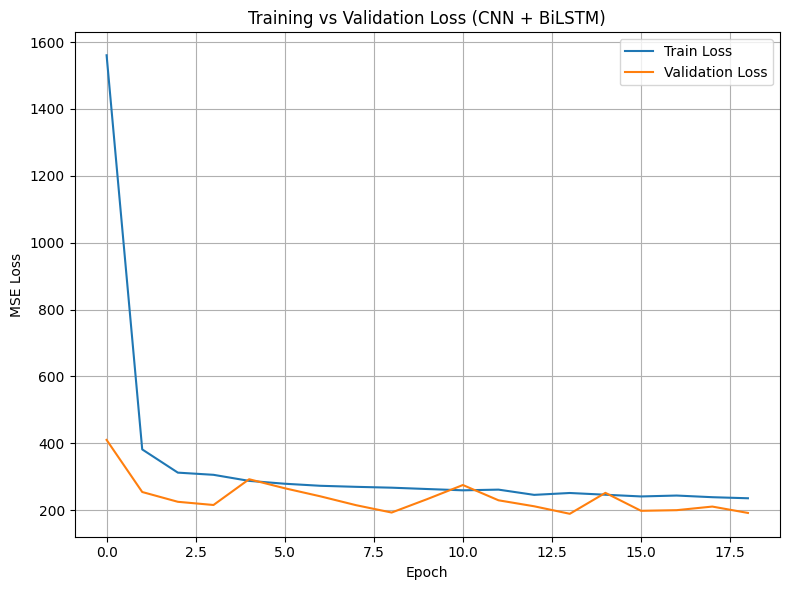

In [15]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("Training vs Validation Loss (CNN + BiLSTM)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("cnn_bilstm_loss_curve.png")
plt.show()


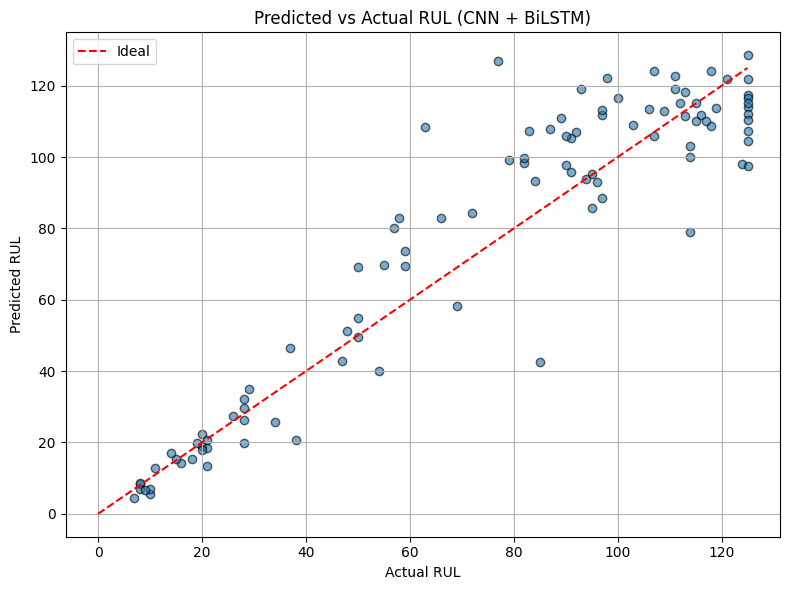

In [16]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.6, edgecolors='k')
plt.plot([0, max(y_test)], [0, max(y_test)], 'r--', label='Ideal')
plt.xlabel("Actual RUL")
plt.ylabel("Predicted RUL")
plt.title("Predicted vs Actual RUL (CNN + BiLSTM)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("cnn_bilstm_pred_vs_actual.png")
plt.show()


In [17]:
# 모델 저장
model.save("cnn_bilstm_rul_model.h5")
print("모델 저장 완료: cnn_bilstm_rul_model.h5")

모델 저장 완료: cnn_bilstm_rul_model.h5


c:\Users\eehfv\anaconda3\envs\br2\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## RNN

In [23]:

# 1. 데이터 불러오기
train = pd.read_csv('train_FD001.txt', sep='\s+', header=None)
test = pd.read_csv('test_FD001.txt', sep='\s+', header=None)
rul = pd.read_csv('RUL_FD001.txt', sep='\s+', header=None)

columns = ['id', 'cycle'] + ['op1', 'op2', 'op3'] + [f'sensor{i}' for i in range(1, 22)]
train.columns = test.columns = columns
rul.columns = ['RUL']

# 2. RUL 생성 + 상한선 125 적용
rul_train = train.groupby('id')['cycle'].max().reset_index()
rul_train.columns = ['id', 'max']
train = train.merge(rul_train, on='id', how='left')
train['RUL'] = np.minimum(train['max'] - train['cycle'], 125)
train.drop(columns='max', inplace=True)

rul['id'] = rul.index + 1
last_cycle = test.groupby('id')['cycle'].max().reset_index()
last_cycle.columns = ['id', 'last_cycle']
rul = rul.merge(last_cycle, on='id')
rul['rul_failed'] = rul['RUL'] + rul['last_cycle']
test = test.merge(rul[['id', 'rul_failed']], on='id', how='left')
test['RUL'] = np.minimum(test['rul_failed'] - test['cycle'], 125)
test.drop(columns='rul_failed', inplace=True)

# 3. 이상치 제거 (센서 기준, 완화된 조건)
sensor_cols = [col for col in train.columns if col.startswith('sensor')]
z_scores = np.abs(train[sensor_cols].apply(zscore))
row_outlier_ratio = (z_scores > 3).sum(axis=1) / len(sensor_cols)
train = train[row_outlier_ratio < 0.5].reset_index(drop=True)

# 4. 중요 센서 선택 (RandomForest 기반)
X_temp = train[sensor_cols + ['op1', 'op2', 'op3']]
y_temp = train['RUL']
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_temp, y_temp)
feature_importances = pd.Series(rf.feature_importances_, index=X_temp.columns)
selected_features = feature_importances.sort_values(ascending=False).head(12).index.tolist()
print(" 선택된 중요 센서 및 운영 변수:", selected_features)

for op in ['op1', 'op2', 'op3']:
    if op not in selected_features:
        selected_features.append(op)

# 5. 정규화
scaler = MinMaxScaler()
train_scaled = train.copy()
test_scaled = test.copy()
train_scaled[selected_features] = scaler.fit_transform(train[selected_features])
test_scaled[selected_features] = scaler.transform(test[selected_features])

# 6. 시계열 시퀀스 생성 함수
def create_sequences(df, seq_len, feature_cols, target_col):
    X, y = [], []
    for _, group in df.groupby('id'):
        group = group.reset_index(drop=True)
        for i in range(len(group) - seq_len):
            seq_x = group.loc[i:i+seq_len-1, feature_cols].values
            seq_y = group.loc[i+seq_len, target_col]
            X.append(seq_x)
            y.append(seq_y)
    return np.array(X), np.array(y)

def create_last_sequences(df, seq_len, feature_cols, target_col):
    X, y = [], []
    for _, group in df.groupby('id'):
        group = group.reset_index(drop=True)
        if len(group) >= seq_len:
            seq_x = group.iloc[-seq_len:][feature_cols].values
            seq_y = group.iloc[-1][target_col]
            X.append(seq_x)
            y.append(seq_y)
    return np.array(X), np.array(y)

# 7. 시퀀스 생성
sequence_length = 30
target_col = 'RUL'
feature_cols = selected_features

X_train, y_train = create_sequences(train_scaled, sequence_length, feature_cols, target_col)
X_test, y_test = create_last_sequences(test_scaled, sequence_length, feature_cols, target_col)

print("학습 샘플 수:", len(X_train), "테스트 샘플 수:", len(X_test))
from tensorflow.keras.layers import SimpleRNN

# 7. RNN 모델 정의
model = Sequential()
model.add(SimpleRNN(100, input_shape=(sequence_length, len(feature_cols))))
model.add(Dense(100, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mse')
model.summary()

# 8. 학습
early_stop = EarlyStopping(patience=5, restore_best_weights=True)
history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stop]
)

# 9. 평가
y_pred = model.predict(X_test).flatten()
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"[RNN] MAE: {mae:.2f}, RMSE: {rmse:.2f}, R²: {r2:.4f}")



 선택된 중요 센서 및 운영 변수: ['sensor11', 'sensor9', 'sensor4', 'sensor12', 'sensor7', 'sensor14', 'sensor15', 'sensor21', 'sensor2', 'sensor3', 'sensor13', 'sensor20']
학습 샘플 수: 17631 테스트 샘플 수: 100
Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 100)               11600     
                                                                 
 dense_14 (Dense)            (None, 100)               10100     
                                                                 
 dropout_7 (Dropout)         (None, 100)               0         
                                                                 
 dense_15 (Dense)            (None, 1)                 101       
                                                                 
Total params: 21801 (85.16 KB)
Trainable params: 21801 (85.16 KB)
Non-trainable params: 0 (0.00 Byte)
___________________________

# 최종모델
## 노이즈 추가 LSTM

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from scipy.stats import zscore

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

from noise_input import RealisticNoiseInjector  #  노이즈 클래스

# 1. 데이터 불러오기
train = pd.read_csv('train_FD001.txt', sep='\s+', header=None)
test = pd.read_csv('test_FD001.txt', sep='\s+', header=None)
rul = pd.read_csv('RUL_FD001.txt', sep='\s+', header=None)

columns = ['id', 'cycle'] + ['op1', 'op2', 'op3'] + [f'sensor{i}' for i in range(1, 22)]
train.columns = test.columns = columns
rul.columns = ['RUL']

# 2. RUL 생성 + 상한선 125 적용
rul_train = train.groupby('id')['cycle'].max().reset_index()
rul_train.columns = ['id', 'max']
train = train.merge(rul_train, on='id', how='left')
train['RUL'] = np.minimum(train['max'] - train['cycle'], 125)
train.drop(columns='max', inplace=True)

rul['id'] = rul.index + 1
last_cycle = test.groupby('id')['cycle'].max().reset_index()
last_cycle.columns = ['id', 'last_cycle']
rul = rul.merge(last_cycle, on='id')
rul['rul_failed'] = rul['RUL'] + rul['last_cycle']
test = test.merge(rul[['id', 'rul_failed']], on='id', how='left')
test['RUL'] = np.minimum(test['rul_failed'] - test['cycle'], 125)
test.drop(columns='rul_failed', inplace=True)

# 3. 이상치 제거 (센서 기준, 완화된 조건)
sensor_cols = [col for col in train.columns if col.startswith('sensor')]
z_scores = np.abs(train[sensor_cols].apply(zscore))
row_outlier_ratio = (z_scores > 3).sum(axis=1) / len(sensor_cols)
train = train[row_outlier_ratio < 0.5].reset_index(drop=True)

# 4. 중요 센서 선택 (RandomForest 기반)
X_temp = train[sensor_cols + ['op1', 'op2', 'op3']]
y_temp = train['RUL']
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_temp, y_temp)
feature_importances = pd.Series(rf.feature_importances_, index=X_temp.columns)
selected_features = feature_importances.sort_values(ascending=False).head(12).index.tolist()
print("선택된 중요 센서 및 운영 변수:", selected_features)

for op in ['op1', 'op2', 'op3']:
    if op not in selected_features:
        selected_features.append(op)

# 5. 노이즈 삽입 + 정규화
noise_injector = RealisticNoiseInjector(seed=42)

X_train_noisy = train[selected_features].copy()
X_train_noisy = X_train_noisy.apply(lambda col: noise_injector.inject(col.values), axis=0)

scaler = MinMaxScaler()
train_scaled = train.copy()
test_scaled = test.copy()
train_scaled[selected_features] = scaler.fit_transform(X_train_noisy)
test_scaled[selected_features] = scaler.transform(test_scaled[selected_features])

# 6. 시계열 시퀀스 생성 함수
# 최근 30개의 센서값을 보고 다음 시점의 RUL을 예측하는 구조
def create_sequences(df, seq_len, feature_cols, target_col):
    X, y = [], []
    for _, group in df.groupby('id'):
        group = group.reset_index(drop=True)
        for i in range(len(group) - seq_len):
            seq_x = group.loc[i:i+seq_len-1, feature_cols].values
            seq_y = group.loc[i+seq_len, target_col]
            X.append(seq_x)
            y.append(seq_y)
    return np.array(X), np.array(y)

def create_last_sequences(df, seq_len, feature_cols, target_col):
    X, y = [], []
    for _, group in df.groupby('id'):
        group = group.reset_index(drop=True)
        if len(group) >= seq_len:
            seq_x = group.iloc[-seq_len:][feature_cols].values
            seq_y = group.iloc[-1][target_col]
            X.append(seq_x)
            y.append(seq_y)
    return np.array(X), np.array(y)

# 7. 시퀀스 생성
sequence_length = 30
target_col = 'RUL'
feature_cols = selected_features

X_train, y_train = create_sequences(train_scaled, sequence_length, feature_cols, target_col)
X_test, y_test = create_last_sequences(test_scaled, sequence_length, feature_cols, target_col)

print("학습 샘플 수:", len(X_train), "테스트 샘플 수:", len(X_test))

# 8. 단일 LSTM 모델 정의
model = Sequential()
model.add(LSTM(100, input_shape=(sequence_length, len(feature_cols))))
model.add(Dense(100, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mse')
model.summary()

# 9. 학습
early_stop = EarlyStopping(patience=5, restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, callbacks=[early_stop])

# 10. 평가
y_pred = model.predict(X_test).flatten()
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
print(f" [LSTM + Noise] MAE: {mae:.2f}, RMSE: {rmse:.2f}, R²: {r2:.4f}")



선택된 중요 센서 및 운영 변수: ['sensor11', 'sensor9', 'sensor4', 'sensor12', 'sensor7', 'sensor14', 'sensor15', 'sensor21', 'sensor2', 'sensor3', 'sensor13', 'sensor20']
학습 샘플 수: 17631 테스트 샘플 수: 100


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100)               46400     
                                                                 
 dense (Dense)               (None, 100)               10100     
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 101       
                                                                 
Total params: 56601 (221.10 KB)
Trainable params: 56601 (221.10 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________

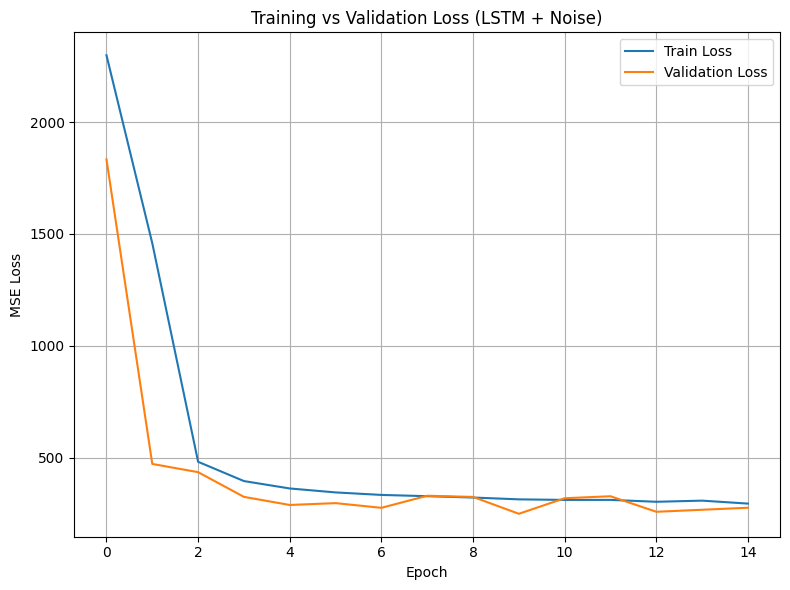

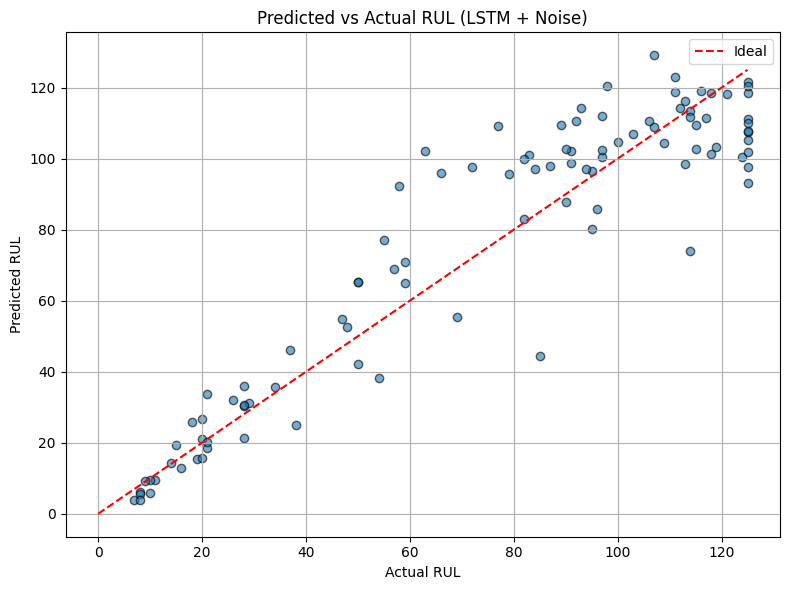

c:\Users\eehfv\anaconda3\envs\br2\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [2]:
# 시각화 및 저장
import matplotlib.pyplot as plt

# 손실 곡선
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title("Training vs Validation Loss (LSTM + Noise)")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("lstm_noise_loss_curve.png")
plt.show()

# 예측 vs 실제 RUL
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.6, edgecolors='k')
plt.plot([0, max(y_test)], [0, max(y_test)], 'r--', label='Ideal')
plt.title("Predicted vs Actual RUL (LSTM + Noise)")
plt.xlabel("Actual RUL")
plt.ylabel("Predicted RUL")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 모델 및 결과 저장
model.save("lstm_noise_rul_model.h5")


4/4 [==============================] - 1s 7ms/step
MAE: 10.88, RMSE: 14.55, R²: 0.8683


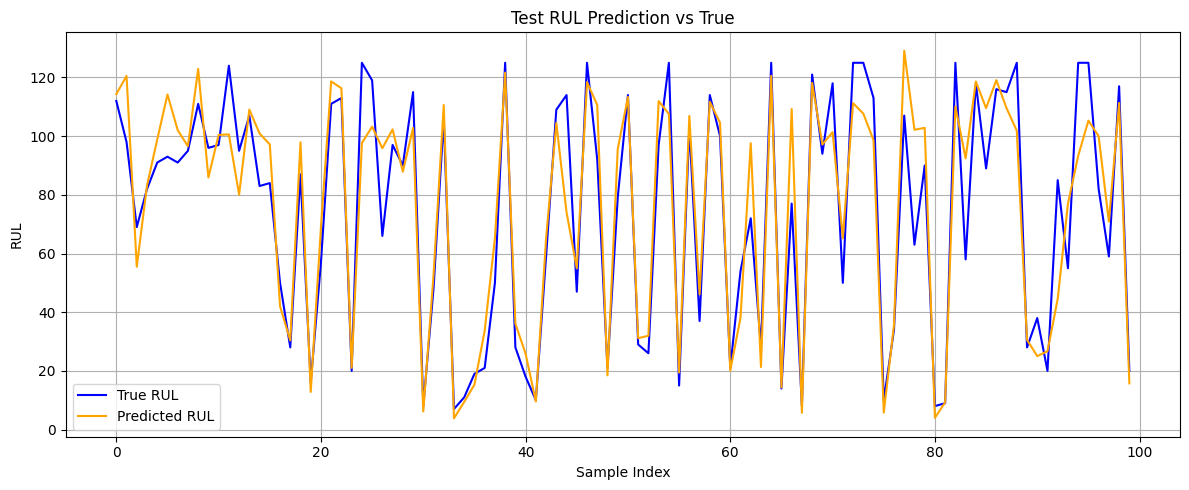

In [3]:
# 예측 결과 vs 실제 RUL 비교
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# 1. 모델 불러오기
model = load_model("lstm_noise_rul_model.h5")

# 2. 테스트 데이터 준비 (이전 전처리와 동일한 방식 유지 필요)
# X_test, y_test 는 이전과 동일한 방식으로 생성되어 있어야 함

# 3. 예측
y_pred = model.predict(X_test).flatten()

# 4. 평가 지표 출력
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
print(f"MAE: {mae:.2f}, RMSE: {rmse:.2f}, R²: {r2:.4f}")

# 5. 시각화
plt.figure(figsize=(12, 5))
plt.plot(y_test[:100], label='True RUL', color='blue')
plt.plot(y_pred[:100], label='Predicted RUL', color='orange')
plt.title("Test RUL Prediction vs True")
plt.xlabel("Sample Index")
plt.ylabel("RUL")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

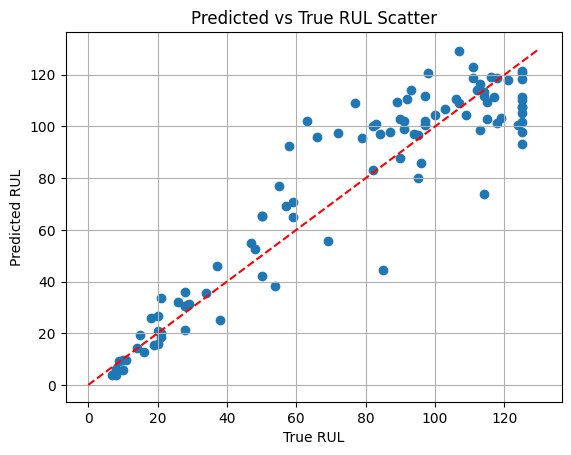

In [4]:
plt.scatter(y_test, y_pred)
plt.plot([0, 130], [0, 130], 'r--')  # y=x 기준선
plt.xlabel("True RUL")
plt.ylabel("Predicted RUL")
plt.title("Predicted vs True RUL Scatter")
plt.grid(True)
plt.show()


In [5]:
#X_test_seq 재생성 및 저장 코드
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from noise_input import RealisticNoiseInjector

# 기존 시퀀스 생성 함수 (반드시 현재 코드에 포함되어야 합니다)
def create_last_sequences(df, seq_len, feature_cols, target_col):
    X, y = [], []
    for _, group in df.groupby('id'):
        group = group.reset_index(drop=True)
        if len(group) >= seq_len:
            seq_x = group.iloc[-seq_len:][feature_cols].values
            seq_y = group.iloc[-1][target_col]
            X.append(seq_x)
            y.append(seq_y)
    return np.array(X), np.array(y)

# 1. 테스트 데이터 로드 및 컬럼 지정
test = pd.read_csv('test_FD001.txt', sep='\s+', header=None)
rul = pd.read_csv('RUL_FD001.txt', sep='\s+', header=None)

columns = ['id', 'cycle'] + ['op1', 'op2', 'op3'] + [f'sensor{i}' for i in range(1, 22)]
test.columns = columns
rul.columns = ['RUL']
rul['id'] = rul.index + 1

# 2. RUL 생성 (상한선 125 적용)
last_cycle = test.groupby('id')['cycle'].max().reset_index()
last_cycle.columns = ['id', 'last_cycle']
rul = rul.merge(last_cycle, on='id')
rul['rul_failed'] = rul['RUL'] + rul['last_cycle']
test = test.merge(rul[['id', 'rul_failed']], on='id', how='left')
test['RUL'] = np.minimum(test['rul_failed'] - test['cycle'], 125)
test.drop(columns='rul_failed', inplace=True)

# 3. 선택된 센서 및 운영 변수 리스트 (RandomForest 기준)
selected_features = [
    'sensor11', 'sensor9', 'sensor4', 'sensor12', 'sensor7',
    'sensor14', 'sensor15', 'sensor21', 'sensor2', 'sensor3',
    'sensor13', 'sensor20', 'op1', 'op2', 'op3'
]

# 4. 훈련 데이터 기반 정규화 기준 생성 (노이즈 포함)
train = pd.read_csv('train_FD001.txt', sep='\s+', header=None)
train.columns = columns
rul_train = train.groupby('id')['cycle'].max().reset_index()
rul_train.columns = ['id', 'max']
train = train.merge(rul_train, on='id', how='left')
train['RUL'] = np.minimum(train['max'] - train['cycle'], 125)
train.drop(columns='max', inplace=True)

noise_injector = RealisticNoiseInjector(seed=42)
X_train_noisy = train[selected_features].copy()
X_train_noisy = X_train_noisy.apply(lambda col: noise_injector.inject(col.values), axis=0)

scaler = MinMaxScaler()
scaler.fit(X_train_noisy)  # 노이즈가 삽입된 학습 데이터를 기준으로 정규화

# 5. 테스트 데이터 정규화
test_scaled = test.copy()
test_scaled[selected_features] = scaler.transform(test_scaled[selected_features])

# 6. 시퀀스 생성 (테스트셋에서 마지막 30주기 기준)
X_test_seq, _ = create_last_sequences(
    df=test_scaled,
    seq_len=30,
    feature_cols=selected_features,
    target_col='RUL'
)

# 7. 저장
np.savez("test_data.npz", X_test_seq=X_test_seq)
print("test_data.npz 저장 완료 - 현재 모델과 호환됩니다.")


test_data.npz 저장 완료 - 현재 모델과 호환됩니다.


4/4 [==============================] - 1s 11ms/step


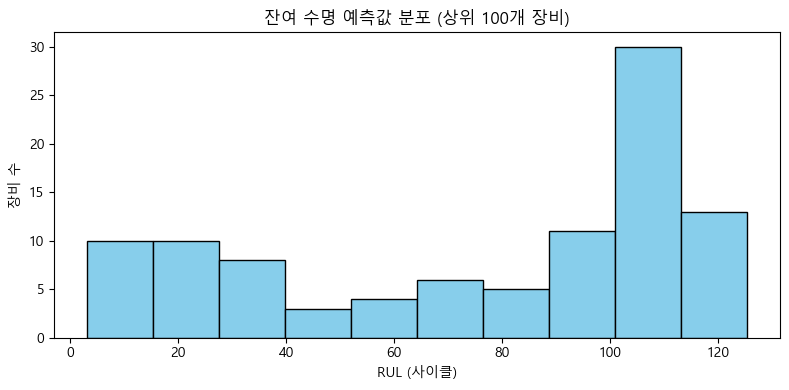

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
import os

# 1. 모델 및 데이터 로딩
model = load_model("lstm_noise_rul_model.h5")
data = np.load("test_data.npz")
X_test_seq = data['X_test_seq']

# 2. 예측
y_pred = model.predict(X_test_seq).flatten()
rul_cycles = y_pred[:100]
rul_hours = np.round(rul_cycles / 60, 2)
rul_id = np.arange(1, len(rul_cycles) + 1)

# 3. DataFrame 생성 및 위험도 분류
rul_df = pd.DataFrame({
    "장비 ID": rul_id,
    "예측 RUL (사이클)": np.round(rul_cycles, 2),
    "환산 시간 (시간)": rul_hours
})
rul_df["위험도"] = pd.cut(rul_df["예측 RUL (사이클)"],
                      bins=[-np.inf, 20, 40, np.inf],
                      labels=["🔴 매우 위험", "🟠 위험", "🟢 양호"])
rul_df = rul_df.sort_values(by="예측 RUL (사이클)").reset_index(drop=True)

# 4. 분포 그래프 저장
os.makedirs('static', exist_ok=True)
plt.figure(figsize=(8, 4))
plt.hist(rul_df["예측 RUL (사이클)"], bins=10, color='skyblue', edgecolor='black')
plt.xlabel("RUL (사이클)")
plt.ylabel("장비 수")
plt.title("잔여 수명 예측값 분포 (상위 100개 장비)")
plt.tight_layout()
# plt.savefig("static/rul_hist.png")
plt.show()
plt.close()

# 5. CSV 저장
# rul_df.to_csv("static/predicted_rul.csv", index=False)
# rul_df[rul_df["위험도"] != "🟢 양호"].to_csv("static/danger_rul.csv", index=False)
# print("예측 완료 및 시각화/CSV 저장 완료")

## 노이즈 추가 BiLSTM

In [27]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from scipy.stats import zscore

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Bidirectional, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

from noise_input import RealisticNoiseInjector

# 1. 데이터 불러오기
train = pd.read_csv('train_FD001.txt', sep='\s+', header=None)
test = pd.read_csv('test_FD001.txt', sep='\s+', header=None)
rul = pd.read_csv('RUL_FD001.txt', sep='\s+', header=None)

columns = ['id', 'cycle'] + ['op1', 'op2', 'op3'] + [f'sensor{i}' for i in range(1, 22)]
train.columns = test.columns = columns
rul.columns = ['RUL']

# 2. RUL 생성 + 상한선 125 적용
rul_train = train.groupby('id')['cycle'].max().reset_index()
rul_train.columns = ['id', 'max']
train = train.merge(rul_train, on='id', how='left')
train['RUL'] = np.minimum(train['max'] - train['cycle'], 125)
train.drop(columns='max', inplace=True)

rul['id'] = rul.index + 1
last_cycle = test.groupby('id')['cycle'].max().reset_index()
last_cycle.columns = ['id', 'last_cycle']
rul = rul.merge(last_cycle, on='id')
rul['rul_failed'] = rul['RUL'] + rul['last_cycle']
test = test.merge(rul[['id', 'rul_failed']], on='id', how='left')
test['RUL'] = np.minimum(test['rul_failed'] - test['cycle'], 125)
test.drop(columns='rul_failed', inplace=True)

# 3. 이상치 제거 (센서 기준, 완화된 조건)
sensor_cols = [col for col in train.columns if col.startswith('sensor')]
z_scores = np.abs(train[sensor_cols].apply(zscore))
row_outlier_ratio = (z_scores > 3).sum(axis=1) / len(sensor_cols)
train = train[row_outlier_ratio < 0.5].reset_index(drop=True)

# 4. 중요 센서 선택 (RandomForest 기반)
X_temp = train[sensor_cols + ['op1', 'op2', 'op3']]
y_temp = train['RUL']
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_temp, y_temp)
feature_importances = pd.Series(rf.feature_importances_, index=X_temp.columns)
selected_features = feature_importances.sort_values(ascending=False).head(12).index.tolist()
print("선택된 중요 센서 및 운영 변수:", selected_features)

# 운영변수 빠져있으면 추가
for op in ['op1', 'op2', 'op3']:
    if op not in selected_features:
        selected_features.append(op)

# 5. 노이즈 삽입 + 정규화
noise_injector = RealisticNoiseInjector(seed=42)

X_train_noisy = train[selected_features].copy()
X_train_noisy = X_train_noisy.apply(lambda col: noise_injector.inject(col.values), axis=0)

scaler = MinMaxScaler()
train_scaled = train.copy()
test_scaled = test.copy()
train_scaled[selected_features] = scaler.fit_transform(X_train_noisy)
test_scaled[selected_features] = scaler.transform(test_scaled[selected_features])

# 6. 시계열 시퀀스 생성 함수
def create_sequences(df, seq_len, feature_cols, target_col):
    X, y = [], []
    for _, group in df.groupby('id'):
        group = group.reset_index(drop=True)
        for i in range(len(group) - seq_len):
            seq_x = group.loc[i:i+seq_len-1, feature_cols].values
            seq_y = group.loc[i+seq_len, target_col]
            X.append(seq_x)
            y.append(seq_y)
    return np.array(X), np.array(y)

def create_last_sequences(df, seq_len, feature_cols, target_col):
    X, y = [], []
    for _, group in df.groupby('id'):
        group = group.reset_index(drop=True)
        if len(group) >= seq_len:
            seq_x = group.iloc[-seq_len:][feature_cols].values
            seq_y = group.iloc[-1][target_col]
            X.append(seq_x)
            y.append(seq_y)
    return np.array(X), np.array(y)

# 7. 시퀀스 생성
sequence_length = 30
target_col = 'RUL'
feature_cols = selected_features

X_train, y_train = create_sequences(train_scaled, sequence_length, feature_cols, target_col)
X_test, y_test = create_last_sequences(test_scaled, sequence_length, feature_cols, target_col)

print(" 학습 샘플 수:", len(X_train), "테스트 샘플 수:", len(X_test))

# 8. Bi-LSTM 모델 정의
model = Sequential()
model.add(Bidirectional(LSTM(100, return_sequences=False), input_shape=(sequence_length, len(feature_cols))))
model.add(Dense(100, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mse')
model.summary()

# 9. 학습 (history 저장)
early_stop = EarlyStopping(patience=5, restore_best_weights=True)
history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stop]
)

# 10. 평가
y_pred = model.predict(X_test).flatten()
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae:.2f}, RMSE: {rmse:.2f}, R²: {r2:.4f}")

선택된 중요 센서 및 운영 변수: ['sensor11', 'sensor9', 'sensor4', 'sensor12', 'sensor7', 'sensor14', 'sensor15', 'sensor21', 'sensor2', 'sensor3', 'sensor13', 'sensor20']
 학습 샘플 수: 17631 테스트 샘플 수: 100
Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_3 (Bidirecti  (None, 200)               92800     
 onal)                                                           
                                                                 
 dense_18 (Dense)            (None, 100)               20100     
                                                                 
 dropout_9 (Dropout)         (None, 100)               0         
                                                                 
 dense_19 (Dense)            (None, 1)                 101       
                                                                 
Total params: 113001 (441.41 KB)
Trainable params: 113001 (441.

## 노이즈 추가 CNN-BiLSTM

In [28]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from scipy.stats import zscore

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Bidirectional, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from noise_input import RealisticNoiseInjector

# 1. 데이터 불러오기
train = pd.read_csv('train_FD001.txt', sep='\s+', header=None)
test = pd.read_csv('test_FD001.txt', sep='\s+', header=None)
rul = pd.read_csv('RUL_FD001.txt', sep='\s+', header=None)

columns = ['id', 'cycle'] + ['op1', 'op2', 'op3'] + [f'sensor{i}' for i in range(1, 22)]
train.columns = test.columns = columns
rul.columns = ['RUL']

# 2. RUL 생성 + 상한선 125 적용
rul_train = train.groupby('id')['cycle'].max().reset_index()
rul_train.columns = ['id', 'max']
train = train.merge(rul_train, on='id', how='left')
train['RUL'] = np.minimum(train['max'] - train['cycle'], 125)
train.drop(columns='max', inplace=True)

rul['id'] = rul.index + 1
last_cycle = test.groupby('id')['cycle'].max().reset_index()
last_cycle.columns = ['id', 'last_cycle']
rul = rul.merge(last_cycle, on='id')
rul['rul_failed'] = rul['RUL'] + rul['last_cycle']
test = test.merge(rul[['id', 'rul_failed']], on='id', how='left')
test['RUL'] = np.minimum(test['rul_failed'] - test['cycle'], 125)
test.drop(columns='rul_failed', inplace=True)

# 3. 이상치 제거 (센서 기준, 완화된 조건)
sensor_cols = [col for col in train.columns if col.startswith('sensor')]
z_scores = np.abs(train[sensor_cols].apply(zscore))
row_outlier_ratio = (z_scores > 3).sum(axis=1) / len(sensor_cols)
train = train[row_outlier_ratio < 0.5].reset_index(drop=True)

# 4. 중요 센서 선택 (RandomForest 기반)
X_temp = train[sensor_cols + ['op1', 'op2', 'op3']]
y_temp = train['RUL']
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_temp, y_temp)
feature_importances = pd.Series(rf.feature_importances_, index=X_temp.columns)
selected_features = feature_importances.sort_values(ascending=False).head(12).index.tolist()
print(" 선택된 중요 센서 및 운영 변수:", selected_features)

for op in ['op1', 'op2', 'op3']:
    if op not in selected_features:
        selected_features.append(op)

# 5. 노이즈 삽입 + 정규화
noise_injector = RealisticNoiseInjector(seed=42)

X_train_noisy = train[selected_features].copy()
X_train_noisy = X_train_noisy.apply(lambda col: noise_injector.inject(col.values), axis=0)

scaler = MinMaxScaler()
train_scaled = train.copy()
test_scaled = test.copy()
train_scaled[selected_features] = scaler.fit_transform(X_train_noisy)
test_scaled[selected_features] = scaler.transform(test_scaled[selected_features])

# 6. 시계열 시퀀스 생성 함수
def create_sequences(df, seq_len, feature_cols, target_col):
    X, y = [], []
    for _, group in df.groupby('id'):
        group = group.reset_index(drop=True)
        for i in range(len(group) - seq_len):
            seq_x = group.loc[i:i+seq_len-1, feature_cols].values
            seq_y = group.loc[i+seq_len, target_col]
            X.append(seq_x)
            y.append(seq_y)
    return np.array(X), np.array(y)

def create_last_sequences(df, seq_len, feature_cols, target_col):
    X, y = [], []
    for _, group in df.groupby('id'):
        group = group.reset_index(drop=True)
        if len(group) >= seq_len:
            seq_x = group.iloc[-seq_len:][feature_cols].values
            seq_y = group.iloc[-1][target_col]
            X.append(seq_x)
            y.append(seq_y)
    return np.array(X), np.array(y)

# 7. 시퀀스 생성
sequence_length = 30
target_col = 'RUL'
feature_cols = selected_features

X_train, y_train = create_sequences(train_scaled, sequence_length, feature_cols, target_col)
X_test, y_test = create_last_sequences(test_scaled, sequence_length, feature_cols, target_col)

print("학습 샘플 수:", len(X_train), "테스트 샘플 수:", len(X_test))

# 8. CNN + Bi-LSTM 모델 정의
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(sequence_length, len(feature_cols))))
model.add(MaxPooling1D(pool_size=2))
model.add(Bidirectional(LSTM(64)))
model.add(Dense(100, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mse')
model.summary()

# 9. 학습
early_stop = EarlyStopping(patience=5, restore_best_weights=True)
history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stop]
)

# 10. 평가
y_pred = model.predict(X_test).flatten()
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae:.2f}, RMSE: {rmse:.2f}, R²: {r2:.4f}")


 선택된 중요 센서 및 운영 변수: ['sensor11', 'sensor9', 'sensor4', 'sensor12', 'sensor7', 'sensor14', 'sensor15', 'sensor21', 'sensor2', 'sensor3', 'sensor13', 'sensor20']
학습 샘플 수: 17631 테스트 샘플 수: 100
Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_1 (Conv1D)           (None, 28, 64)            2944      
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 14, 64)            0         
 g1D)                                                            
                                                                 
 bidirectional_4 (Bidirecti  (None, 128)               66048     
 onal)                                                           
                                                                 
 dense_20 (Dense)            (None, 100)               12900     
                                                              

## 노이즈 추가 RNN

In [31]:
from noise_input import RealisticNoiseInjector
# 1. 데이터 불러오기
train = pd.read_csv('train_FD001.txt', sep='\s+', header=None)
test = pd.read_csv('test_FD001.txt', sep='\s+', header=None)
rul = pd.read_csv('RUL_FD001.txt', sep='\s+', header=None)

columns = ['id', 'cycle'] + ['op1', 'op2', 'op3'] + [f'sensor{i}' for i in range(1, 22)]
train.columns = test.columns = columns
rul.columns = ['RUL']

# 2. RUL 생성 + 상한선 125 적용
rul_train = train.groupby('id')['cycle'].max().reset_index()
rul_train.columns = ['id', 'max']
train = train.merge(rul_train, on='id', how='left')
train['RUL'] = np.minimum(train['max'] - train['cycle'], 125)
train.drop(columns='max', inplace=True)

rul['id'] = rul.index + 1
last_cycle = test.groupby('id')['cycle'].max().reset_index()
last_cycle.columns = ['id', 'last_cycle']
rul = rul.merge(last_cycle, on='id')
rul['rul_failed'] = rul['RUL'] + rul['last_cycle']
test = test.merge(rul[['id', 'rul_failed']], on='id', how='left')
test['RUL'] = np.minimum(test['rul_failed'] - test['cycle'], 125)
test.drop(columns='rul_failed', inplace=True)

# 3. 이상치 제거 (센서 기준, 완화된 조건)
sensor_cols = [col for col in train.columns if col.startswith('sensor')]
z_scores = np.abs(train[sensor_cols].apply(zscore))
row_outlier_ratio = (z_scores > 3).sum(axis=1) / len(sensor_cols)
train = train[row_outlier_ratio < 0.5].reset_index(drop=True)

# 4. 중요 센서 선택 (RandomForest 기반)
X_temp = train[sensor_cols + ['op1', 'op2', 'op3']]
y_temp = train['RUL']
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_temp, y_temp)
feature_importances = pd.Series(rf.feature_importances_, index=X_temp.columns)
selected_features = feature_importances.sort_values(ascending=False).head(12).index.tolist()
print(" 선택된 중요 센서 및 운영 변수:", selected_features)

for op in ['op1', 'op2', 'op3']:
    if op not in selected_features:
        selected_features.append(op)

# 5. 노이즈 삽입 + 정규화
noise_injector = RealisticNoiseInjector(seed=42)

X_train_noisy = train[selected_features].copy()
X_train_noisy = X_train_noisy.apply(lambda col: noise_injector.inject(col.values), axis=0)

scaler = MinMaxScaler()
train_scaled = train.copy()
test_scaled = test.copy()
train_scaled[selected_features] = scaler.fit_transform(X_train_noisy)
test_scaled[selected_features] = scaler.transform(test_scaled[selected_features])

# 6. 시계열 시퀀스 생성 함수
def create_sequences(df, seq_len, feature_cols, target_col):
    X, y = [], []
    for _, group in df.groupby('id'):
        group = group.reset_index(drop=True)
        for i in range(len(group) - seq_len):
            seq_x = group.loc[i:i+seq_len-1, feature_cols].values
            seq_y = group.loc[i+seq_len, target_col]
            X.append(seq_x)
            y.append(seq_y)
    return np.array(X), np.array(y)

def create_last_sequences(df, seq_len, feature_cols, target_col):
    X, y = [], []
    for _, group in df.groupby('id'):
        group = group.reset_index(drop=True)
        if len(group) >= seq_len:
            seq_x = group.iloc[-seq_len:][feature_cols].values
            seq_y = group.iloc[-1][target_col]
            X.append(seq_x)
            y.append(seq_y)
    return np.array(X), np.array(y)

# 7. 시퀀스 생성
sequence_length = 30
target_col = 'RUL'
feature_cols = selected_features

X_train, y_train = create_sequences(train_scaled, sequence_length, feature_cols, target_col)
X_test, y_test = create_last_sequences(test_scaled, sequence_length, feature_cols, target_col)

print("학습 샘플 수:", len(X_train), "테스트 샘플 수:", len(X_test))
from tensorflow.keras.layers import SimpleRNN

# 7. RNN 모델 정의
model = Sequential()
model.add(SimpleRNN(100, input_shape=(sequence_length, len(feature_cols))))
model.add(Dense(100, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mse')
model.summary()

# 8. 학습
early_stop = EarlyStopping(patience=5, restore_best_weights=True)
history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stop]
)

# 9. 평가
y_pred = model.predict(X_test).flatten()
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"[RNN] MAE: {mae:.2f}, RMSE: {rmse:.2f}, R²: {r2:.4f}")

 선택된 중요 센서 및 운영 변수: ['sensor11', 'sensor9', 'sensor4', 'sensor12', 'sensor7', 'sensor14', 'sensor15', 'sensor21', 'sensor2', 'sensor3', 'sensor13', 'sensor20']
학습 샘플 수: 17631 테스트 샘플 수: 100
Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_1 (SimpleRNN)    (None, 100)               11600     
                                                                 
 dense_22 (Dense)            (None, 100)               10100     
                                                                 
 dropout_11 (Dropout)        (None, 100)               0         
                                                                 
 dense_23 (Dense)            (None, 1)                 101       
                                                                 
Total params: 21801 (85.16 KB)
Trainable params: 21801 (85.16 KB)
Non-trainable params: 0 (0.00 Byte)
__________________________

In [32]:
# 모델 저장
model.save("RNN_noise_rul_model.h5")
print("모델 저장 완료: RNN_noise_rul_model.h5")

c:\Users\eehfv\anaconda3\envs\br2\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


모델 저장 완료: RNN_noise_rul_model.h5


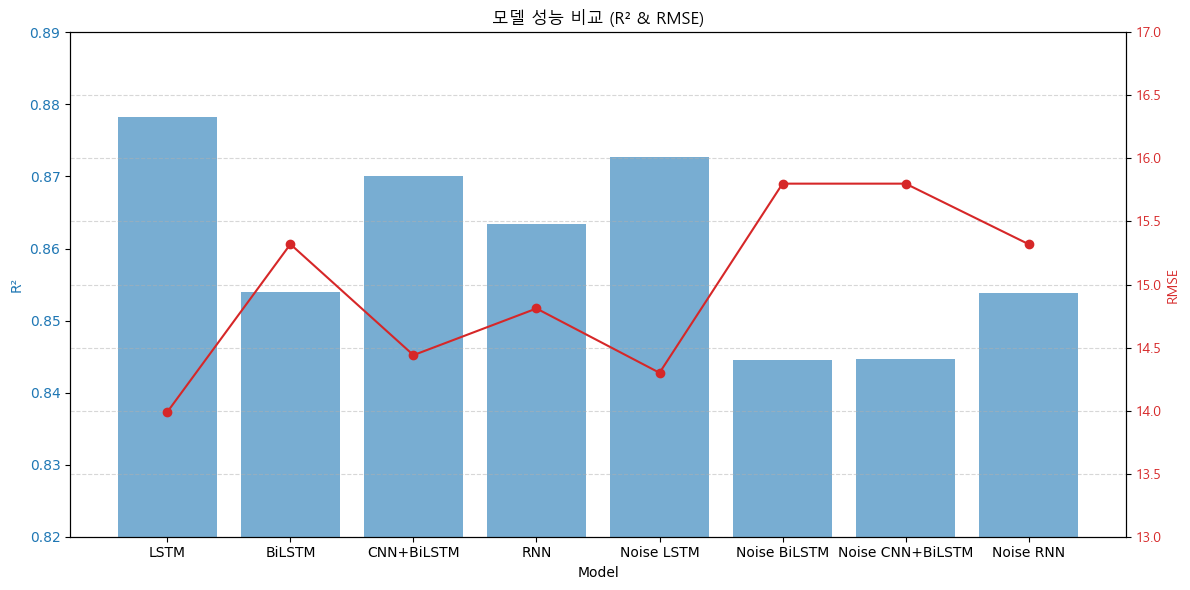

In [34]:
# 모델별 R² + RMSE 시각화
import matplotlib.pyplot as plt

models = ['LSTM', 'BiLSTM', 'CNN+BiLSTM', 'RNN', 
          'Noise LSTM', 'Noise BiLSTM', 'Noise CNN+BiLSTM', 'Noise RNN']

r2_scores = [0.8782, 0.8539, 0.8701, 0.8634, 0.8727, 0.8445, 0.8446, 0.8538]
rmse_scores = [13.99, 15.32, 14.44, 14.81, 14.3, 15.8, 15.8, 15.32]

fig, ax1 = plt.subplots(figsize=(12, 6))
plt.rcParams['font.family']= 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False
# R²
color = 'tab:blue'
ax1.set_xlabel('Model')
ax1.set_ylabel('R²', color=color)
ax1.bar(models, r2_scores, color=color, alpha=0.6, label='R²')
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_ylim(0.82, 0.89)

# RMSE
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('RMSE', color=color)
ax2.plot(models, rmse_scores, color=color, marker='o', label='RMSE')
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_ylim(13, 17)

plt.title('모델 성능 비교 (R² & RMSE)')
fig.tight_layout()
plt.xticks(rotation=45)
plt.grid(True, axis='y', linestyle='--', alpha=0.5)
plt.savefig('model_comparison_r2_rmse.png')
plt.show()


## 모델별 성능 시각화

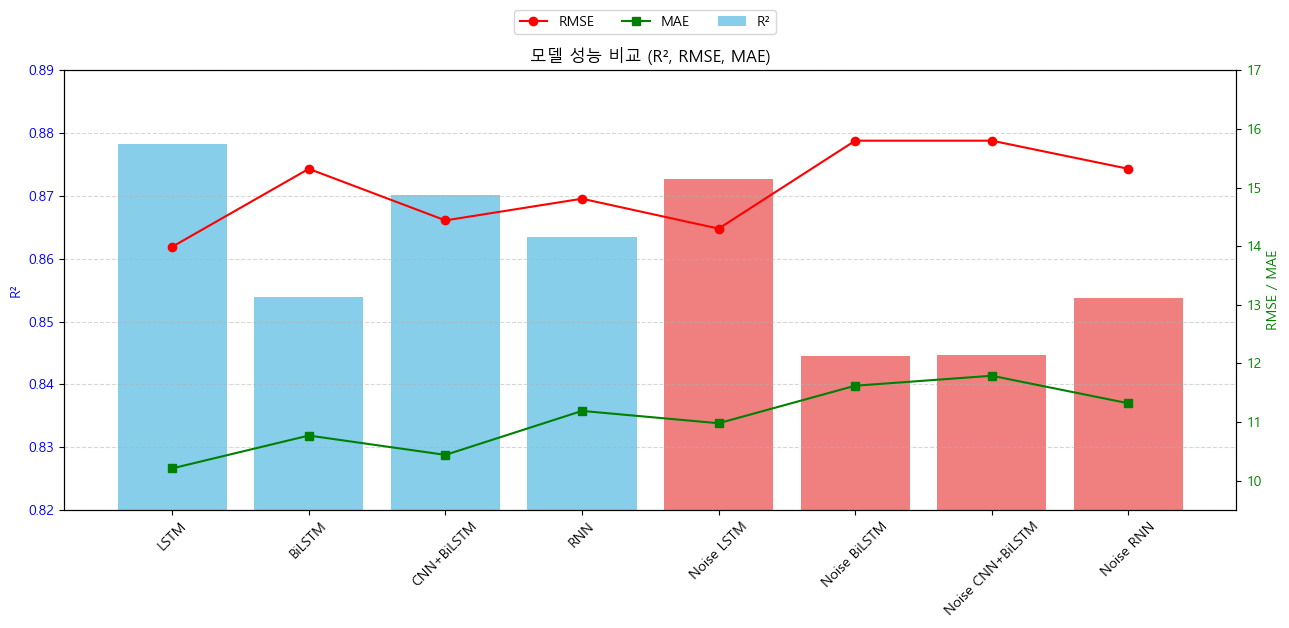

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# 데이터 정의
models = ['LSTM', 'BiLSTM', 'CNN+BiLSTM', 'RNN',
          'Noise LSTM', 'Noise BiLSTM', 'Noise CNN+BiLSTM', 'Noise RNN']

r2_scores = [0.8782, 0.8539, 0.8701, 0.8634, 0.8727, 0.8445, 0.8446, 0.8538]
rmse_scores = [13.99, 15.32, 14.44, 14.81, 14.30, 15.80, 15.80, 15.32]
mae_scores = [10.21, 10.77, 10.44, 11.19, 10.98, 11.62, 11.79, 11.32]

x = np.arange(len(models))
colors = ['skyblue' if 'Noise' not in m else 'lightcoral' for m in models]

fig, ax1 = plt.subplots(figsize=(13, 6))

#  R² 막대 그래프
bar = ax1.bar(x, r2_scores, color=colors, label='R²')
ax1.set_ylabel("R²", color='blue')
ax1.set_ylim(0.82, 0.89)
ax1.set_xticks(x)
ax1.set_xticklabels(models, rotation=45)
ax1.tick_params(axis='y', labelcolor='blue')

#  RMSE + MAE 라인 그래프
ax2 = ax1.twinx()
line1 = ax2.plot(x, rmse_scores, color='red', marker='o', label='RMSE')
line2 = ax2.plot(x, mae_scores, color='green', marker='s', label='MAE')
ax2.set_ylabel("RMSE / MAE", color='green')  # 오른쪽 축은 중립색
ax2.set_ylim(9.5, 17)
ax2.tick_params(axis='y', labelcolor='green')

#  범례
lines = line1 + line2 + [bar]
labels = [l.get_label() for l in lines]
fig.legend(lines, labels, loc='upper center', bbox_to_anchor=(0.5, 1.05), ncol=3)

#  제목 + 그리드
ax1.set_title("모델 성능 비교 (R², RMSE, MAE)")
ax1.grid(True, axis='y', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()


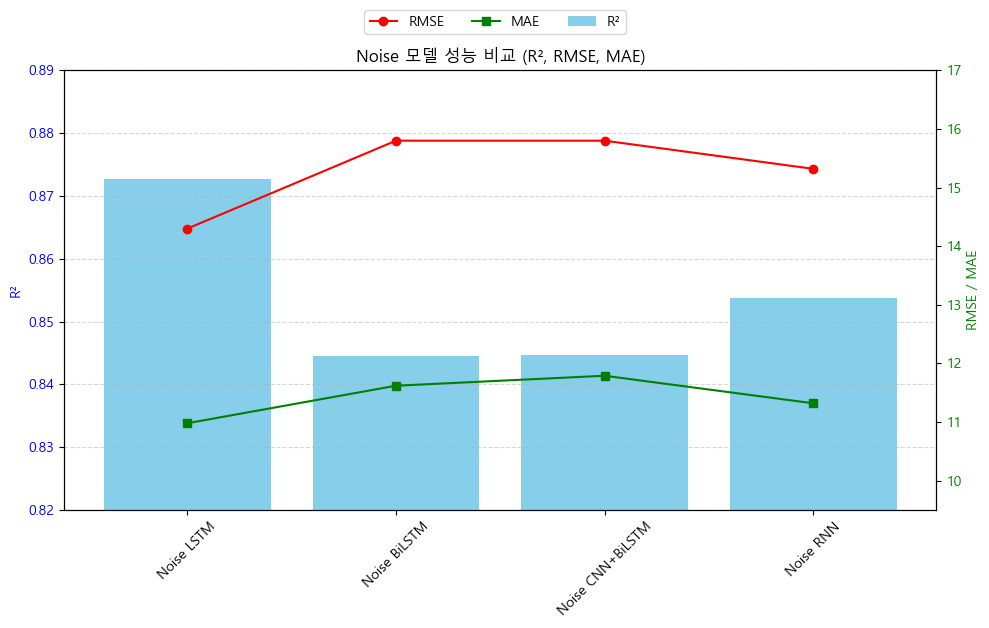

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Noise 모델 데이터
models = ['Noise LSTM', 'Noise BiLSTM', 'Noise CNN+BiLSTM', 'Noise RNN']
r2_scores = [0.8727, 0.8445, 0.8446, 0.8538]
rmse_scores = [14.30, 15.80, 15.80, 15.32]
mae_scores = [10.98, 11.62, 11.79, 11.32]

x = np.arange(len(models))

fig, ax1 = plt.subplots(figsize=(10, 6))

#  R² 막대 그래프 (하늘색)
bar = ax1.bar(x, r2_scores, color='skyblue', label='R²')
ax1.set_ylabel("R²", color='blue')
ax1.set_ylim(0.82, 0.89)
ax1.set_xticks(x)
ax1.set_xticklabels(models, rotation=45)
ax1.tick_params(axis='y', labelcolor='blue')

#  RMSE + MAE 라인 그래프
ax2 = ax1.twinx()
line1 = ax2.plot(x, rmse_scores, color='red', marker='o', label='RMSE')
line2 = ax2.plot(x, mae_scores, color='green', marker='s', label='MAE')
ax2.set_ylabel("RMSE / MAE", color='green')
ax2.set_ylim(9.5, 17)
ax2.tick_params(axis='y', labelcolor='green')

# 범례
lines = line1 + line2 + [bar]
labels = [l.get_label() for l in lines]
fig.legend(lines, labels, loc='upper center', bbox_to_anchor=(0.5, 1.05), ncol=3)

#  제목 + 그리드
ax1.set_title("Noise 모델 성능 비교 (R², RMSE, MAE)")
ax1.grid(True, axis='y', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()


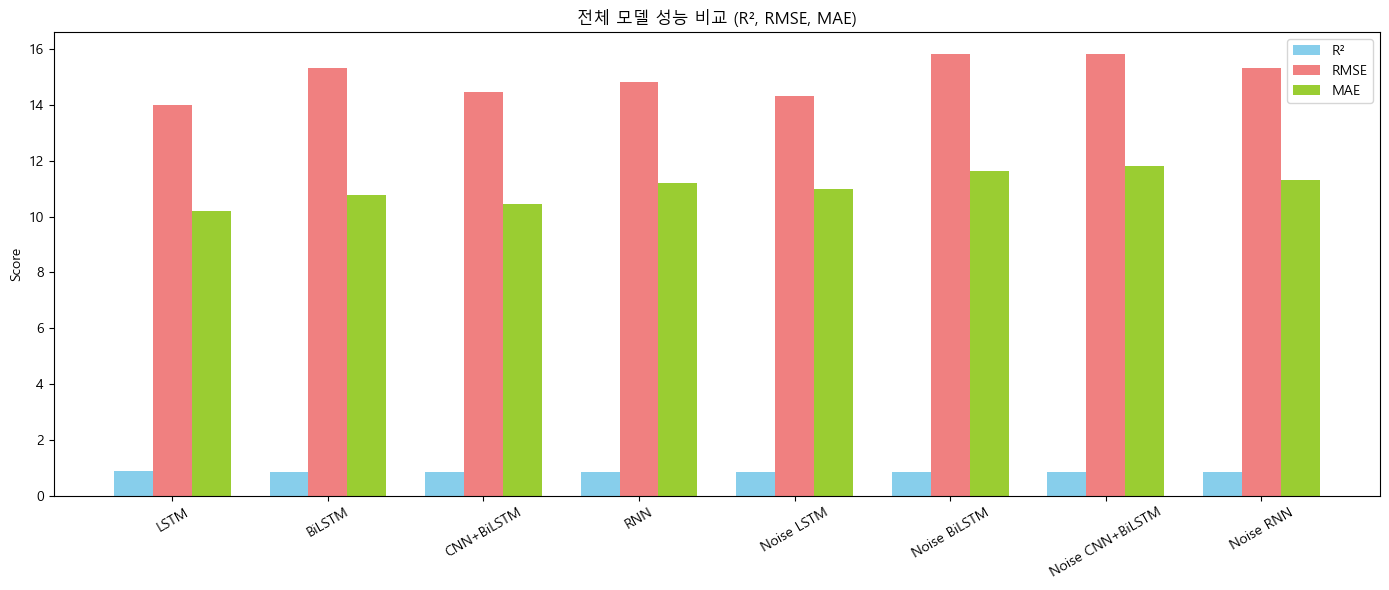

In [44]:
# 노이즈 추가 한것과 안한 모델 총 8개 모델 시각화
import matplotlib.pyplot as plt
import numpy as np

# 모델명 및 실제 수치 입력
models = ['LSTM', 'BiLSTM', 'CNN+BiLSTM', 'RNN', 
          'Noise LSTM', 'Noise BiLSTM', 'Noise CNN+BiLSTM', 'Noise RNN']
mae = [10.21, 10.77, 10.44, 11.19, 10.98, 11.62, 11.79, 11.32]
rmse = [13.99, 15.32, 14.44, 14.81, 14.3, 15.8, 15.8, 15.32]
r2 = [0.8782, 0.8539, 0.8701, 0.8634, 0.8727, 0.8445, 0.8446, 0.8538]

# 막대 위치
x = np.arange(len(models))
width = 0.25

plt.figure(figsize=(14, 6))
plt.bar(x - width, r2, width, label='R²', color='skyblue')
plt.bar(x, rmse, width, label='RMSE', color='lightcoral')
plt.bar(x + width, mae, width, label='MAE', color='yellowgreen')

plt.xticks(x, models, rotation=30)
plt.ylabel('Score')
plt.title('전체 모델 성능 비교 (R², RMSE, MAE)')
plt.legend()
plt.tight_layout()
plt.show()


######################################################################################################################

#######################################################################################################################

# 추가 분석 
- (노이즈 + LSTM 모델에 레이어 깊게, sequence함수 바꿈)-->성능 하락

## 노이즈 추가+ LSTM
- 표준편차 기준 변화 적은 센서 제거해보았지만 성능 하락

In [55]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from scipy.stats import zscore

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

from noise_input import RealisticNoiseInjector  # 노이즈 클래스

# 1. 데이터 불러오기
train = pd.read_csv('train_FD001.txt', sep='\s+', header=None)
test = pd.read_csv('test_FD001.txt', sep='\s+', header=None)
rul = pd.read_csv('RUL_FD001.txt', sep='\s+', header=None)

columns = ['id', 'cycle'] + ['op1', 'op2', 'op3'] + [f'sensor{i}' for i in range(1, 22)]
train.columns = test.columns = columns
rul.columns = ['RUL']

# 2. RUL 생성 + 상한선 125 적용
rul_train = train.groupby('id')['cycle'].max().reset_index()
rul_train.columns = ['id', 'max']
train = train.merge(rul_train, on='id', how='left')
train['RUL'] = np.minimum(train['max'] - train['cycle'], 125)
train.drop(columns='max', inplace=True)

rul['id'] = rul.index + 1
last_cycle = test.groupby('id')['cycle'].max().reset_index()
last_cycle.columns = ['id', 'last_cycle']
rul = rul.merge(last_cycle, on='id')
rul['rul_failed'] = rul['RUL'] + rul['last_cycle']
test = test.merge(rul[['id', 'rul_failed']], on='id', how='left')
test['RUL'] = np.minimum(test['rul_failed'] - test['cycle'], 125)
test.drop(columns='rul_failed', inplace=True)

# 3. 이상치 제거 (센서 기준)
sensor_cols_all = [col for col in train.columns if col.startswith('sensor')]
z_scores = np.abs(train[sensor_cols_all].apply(zscore))
row_outlier_ratio = (z_scores > 3).sum(axis=1) / len(sensor_cols_all)
train = train[row_outlier_ratio < 0.5].reset_index(drop=True)

# 4. 표준편차 기준으로 변화 적은 센서 제거
low_var_sensors = ['sensor1', 'sensor5', 'sensor6', 'sensor8', 'sensor10', 
                   'sensor11', 'sensor13', 'sensor15', 'sensor16', 'sensor18',
                   'sensor19', 'sensor20', 'sensor21']
sensor_cols = [s for s in sensor_cols_all if s not in low_var_sensors]

# 5. RandomForest 기반 중요 센서 선택
X_temp = train[sensor_cols + ['op1', 'op2', 'op3']]
y_temp = train['RUL']
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_temp, y_temp)
feature_importances = pd.Series(rf.feature_importances_, index=X_temp.columns)
selected_features = feature_importances.sort_values(ascending=False).head(12).index.tolist()

# 운영변수 포함 확인
for op in ['op1', 'op2', 'op3']:
    if op not in selected_features:
        selected_features.append(op)

print("최종 선택된 센서 및 운영 변수:", selected_features)

# 6. 노이즈 삽입 + 정규화
noise_injector = RealisticNoiseInjector(seed=42)
X_train_noisy = train[selected_features].copy()
X_train_noisy = X_train_noisy.apply(lambda col: noise_injector.inject(col.values.astype(float)), axis=0)

scaler = MinMaxScaler()
train_scaled = train.copy()
test_scaled = test.copy()
train_scaled[selected_features] = scaler.fit_transform(X_train_noisy)
test_scaled[selected_features] = scaler.transform(test_scaled[selected_features])

# 7. 시계열 시퀀스 생성 함수
def create_sequences(df, seq_len, feature_cols, target_col):
    X, y = [], []
    for _, group in df.groupby('id'):
        group = group.reset_index(drop=True)
        for i in range(len(group) - seq_len):
            seq_x = group.loc[i:i+seq_len-1, feature_cols].values
            seq_y = group.loc[i+seq_len, target_col]
            X.append(seq_x)
            y.append(seq_y)
    return np.array(X), np.array(y)

def create_last_sequences(df, seq_len, feature_cols, target_col):
    X, y = [], []
    for _, group in df.groupby('id'):
        group = group.reset_index(drop=True)
        if len(group) >= seq_len:
            seq_x = group.iloc[-seq_len:][feature_cols].values
            seq_y = group.iloc[-1][target_col]
            X.append(seq_x)
            y.append(seq_y)
    return np.array(X), np.array(y)

# 8. 시퀀스 생성
sequence_length = 30
target_col = 'RUL'
feature_cols = selected_features

X_train, y_train = create_sequences(train_scaled, sequence_length, feature_cols, target_col)
X_test, y_test = create_last_sequences(test_scaled, sequence_length, feature_cols, target_col)

print("학습 샘플 수:", len(X_train), "테스트 샘플 수:", len(X_test))

# 9. 단일 LSTM 모델 정의
model = Sequential()
model.add(LSTM(100, input_shape=(sequence_length, len(feature_cols))))
model.add(Dense(100, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mse')
model.summary()

# 10. 학습
early_stop = EarlyStopping(patience=5, restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, callbacks=[early_stop])

# 11. 평가
y_pred = model.predict(X_test).flatten()
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"\n [최종 Noise LSTM] MAE: {mae:.2f}, RMSE: {rmse:.2f}, R²: {r2:.4f}")

최종 선택된 센서 및 운영 변수: ['sensor4', 'sensor9', 'sensor12', 'sensor7', 'sensor14', 'sensor2', 'sensor3', 'op1', 'op2', 'sensor17', 'op3']
학습 샘플 수: 17631 테스트 샘플 수: 100
Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_10 (LSTM)              (None, 100)               44800     
                                                                 
 dense_24 (Dense)            (None, 100)               10100     
                                                                 
 dropout_12 (Dropout)        (None, 100)               0         
                                                                 
 dense_25 (Dense)            (None, 1)                 101       
                                                                 
Total params: 55001 (214.85 KB)
Trainable params: 55001 (214.85 KB)
Non-trainable params: 0 (0.00 Byte)
____________________________________________________

## 노이즈 + LSTM
- 레이어 더 깊게, sequence함수 변경

In [58]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from scipy.stats import zscore

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping

from noise_input import RealisticNoiseInjector  # 노이즈 클래스

# 1. 데이터 불러오기
train = pd.read_csv('train_FD001.txt', sep='\s+', header=None)
test = pd.read_csv('test_FD001.txt', sep='\s+', header=None)
rul = pd.read_csv('RUL_FD001.txt', sep='\s+', header=None)

columns = ['id', 'cycle'] + ['op1', 'op2', 'op3'] + [f'sensor{i}' for i in range(1, 22)]
train.columns = test.columns = columns
rul.columns = ['RUL']

# 2. RUL 생성 + 상한선 125 적용
rul_train = train.groupby('id')['cycle'].max().reset_index()
rul_train.columns = ['id', 'max']
train = train.merge(rul_train, on='id', how='left')
train['RUL'] = np.minimum(train['max'] - train['cycle'], 125)
train.drop(columns='max', inplace=True)

rul['id'] = rul.index + 1
last_cycle = test.groupby('id')['cycle'].max().reset_index()
last_cycle.columns = ['id', 'last_cycle']
rul = rul.merge(last_cycle, on='id')
rul['rul_failed'] = rul['RUL'] + rul['last_cycle']
test = test.merge(rul[['id', 'rul_failed']], on='id', how='left')
test['RUL'] = np.minimum(test['rul_failed'] - test['cycle'], 125)
test.drop(columns='rul_failed', inplace=True)

# 3. 이상치 제거 (센서 기준, 완화된 조건)
sensor_cols = [col for col in train.columns if col.startswith('sensor')]
z_scores = np.abs(train[sensor_cols].apply(zscore))
row_outlier_ratio = (z_scores > 3).sum(axis=1) / len(sensor_cols)
train = train[row_outlier_ratio < 0.5].reset_index(drop=True)

# 4. 중요 센서 선택 (RandomForest 기반)
X_temp = train[sensor_cols + ['op1', 'op2', 'op3']]
y_temp = train['RUL']
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_temp, y_temp)
feature_importances = pd.Series(rf.feature_importances_, index=X_temp.columns)
selected_features = feature_importances.sort_values(ascending=False).head(12).index.tolist()
print("선택된 중요 센서 및 운영 변수:", selected_features)

for op in ['op1', 'op2', 'op3']:
    if op not in selected_features:
        selected_features.append(op)

# 5. 노이즈 삽입 + 정규화
noise_injector = RealisticNoiseInjector(seed=42)
X_train_noisy = train[selected_features].copy()
X_train_noisy = X_train_noisy.apply(lambda col: noise_injector.inject(col.values), axis=0)

scaler = MinMaxScaler()
train_scaled = train.copy()
test_scaled = test.copy()
train_scaled[selected_features] = scaler.fit_transform(X_train_noisy)
test_scaled[selected_features] = scaler.transform(test_scaled[selected_features])

# 6. 시계열 시퀀스 생성 함수
def create_sequences(df, seq_len, feature_cols, target_col):
    X, y = [], []
    for _, group in df.groupby('id'):
        group = group.reset_index(drop=True)
        for i in range(len(group) - seq_len):
            seq_x = group.loc[i:i+seq_len-1, feature_cols].values
            seq_y = group.loc[i+seq_len, target_col]
            X.append(seq_x)
            y.append(seq_y)
    return np.array(X), np.array(y)

def create_last_sequences(df, seq_len, feature_cols, target_col):
    X, y = [], []
    for _, group in df.groupby('id'):
        group = group.reset_index(drop=True)
        if len(group) >= seq_len:
            seq_x = group.iloc[-seq_len:][feature_cols].values
            seq_y = group.iloc[-1][target_col]
            X.append(seq_x)
            y.append(seq_y)
    return np.array(X), np.array(y)

# 7. 시퀀스 생성
sequence_length = 30
target_col = 'RUL'
feature_cols = selected_features

X_train, y_train = create_sequences(train_scaled, sequence_length, feature_cols, target_col)
X_test, y_test = create_last_sequences(test_scaled, sequence_length, feature_cols, target_col)

print("학습 샘플 수:", len(X_train), "테스트 샘플 수:", len(X_test))

# 8. LSTM 모델 정의 (128 → 64 → 32 → Dense)
model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape=(sequence_length, len(feature_cols))))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(LSTM(64, return_sequences=True))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(LSTM(32))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(1))  # 최종 RUL 예측

model.compile(optimizer='adam', loss='mse')
model.summary()

# 9. 학습
early_stop = EarlyStopping(patience=5, restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, callbacks=[early_stop])

# 10. 평가
y_pred = model.predict(X_test).flatten()
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"[LSTM Deep + Noise] MAE: {mae:.2f}, RMSE: {rmse:.2f}, R²: {r2:.4f}")


선택된 중요 센서 및 운영 변수: ['sensor11', 'sensor9', 'sensor4', 'sensor12', 'sensor7', 'sensor14', 'sensor15', 'sensor21', 'sensor2', 'sensor3', 'sensor13', 'sensor20']
학습 샘플 수: 17631 테스트 샘플 수: 100
Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_17 (LSTM)              (None, 30, 128)           73728     
                                                                 
 batch_normalization_4 (Bat  (None, 30, 128)           512       
 chNormalization)                                                
                                                                 
 dropout_19 (Dropout)        (None, 30, 128)           0         
                                                                 
 lstm_18 (LSTM)              (None, 30, 64)            49408     
                                                                 
 batch_normalization_5 (Bat  (None, 30, 64)            256     

In [60]:
# 노이즈 + LSTM (단순레이어, 시퀀스 변경)
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from scipy.stats import zscore

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping

from noise_input import RealisticNoiseInjector  # 노이즈 클래스

# 1. 데이터 불러오기
train = pd.read_csv('train_FD001.txt', sep='\s+', header=None)
test = pd.read_csv('test_FD001.txt', sep='\s+', header=None)
rul = pd.read_csv('RUL_FD001.txt', sep='\s+', header=None)

columns = ['id', 'cycle'] + ['op1', 'op2', 'op3'] + [f'sensor{i}' for i in range(1, 22)]
train.columns = test.columns = columns
rul.columns = ['RUL']

# 2. RUL 생성 + 상한선 125 적용
rul_train = train.groupby('id')['cycle'].max().reset_index()
rul_train.columns = ['id', 'max']
train = train.merge(rul_train, on='id', how='left')
train['RUL'] = np.minimum(train['max'] - train['cycle'], 125)
train.drop(columns='max', inplace=True)

rul['id'] = rul.index + 1
last_cycle = test.groupby('id')['cycle'].max().reset_index()
last_cycle.columns = ['id', 'last_cycle']
rul = rul.merge(last_cycle, on='id')
rul['rul_failed'] = rul['RUL'] + rul['last_cycle']
test = test.merge(rul[['id', 'rul_failed']], on='id', how='left')
test['RUL'] = np.minimum(test['rul_failed'] - test['cycle'], 125)
test.drop(columns='rul_failed', inplace=True)

# 3. 이상치 제거 (센서 기준, 완화된 조건)
sensor_cols = [col for col in train.columns if col.startswith('sensor')]
z_scores = np.abs(train[sensor_cols].apply(zscore))
row_outlier_ratio = (z_scores > 3).sum(axis=1) / len(sensor_cols)
train = train[row_outlier_ratio < 0.5].reset_index(drop=True)

# 4. 중요 센서 선택 (RandomForest 기반)
X_temp = train[sensor_cols + ['op1', 'op2', 'op3']]
y_temp = train['RUL']
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_temp, y_temp)
feature_importances = pd.Series(rf.feature_importances_, index=X_temp.columns)
selected_features = feature_importances.sort_values(ascending=False).head(12).index.tolist()
print("선택된 중요 센서 및 운영 변수:", selected_features)

for op in ['op1', 'op2', 'op3']:
    if op not in selected_features:
        selected_features.append(op)

# 5. 노이즈 삽입 + 정규화
noise_injector = RealisticNoiseInjector(seed=42)
X_train_noisy = train[selected_features].copy()
X_train_noisy = X_train_noisy.apply(lambda col: noise_injector.inject(col.values), axis=0)

scaler = MinMaxScaler()
train_scaled = train.copy()
test_scaled = test.copy()
train_scaled[selected_features] = scaler.fit_transform(X_train_noisy)
test_scaled[selected_features] = scaler.transform(test_scaled[selected_features])

# 6. 시계열 시퀀스 생성 함수
def create_sequences(df, seq_len, feature_cols, target_col):
    X, y = [], []
    for _, group in df.groupby('id'):
        group = group.reset_index(drop=True)
        for i in range(len(group) - seq_len):
            seq_x = group.loc[i:i+seq_len-1, feature_cols].values
            seq_y = group.loc[i+seq_len, target_col]
            X.append(seq_x)
            y.append(seq_y)
    return np.array(X), np.array(y)

def create_last_sequences(df, seq_len, feature_cols, target_col):
    X, y = [], []
    for _, group in df.groupby('id'):
        group = group.reset_index(drop=True)
        if len(group) >= seq_len:
            seq_x = group.iloc[-seq_len:][feature_cols].values
            seq_y = group.iloc[-1][target_col]
            X.append(seq_x)
            y.append(seq_y)
    return np.array(X), np.array(y)

# 7. 시퀀스 생성
sequence_length = 30
target_col = 'RUL'
feature_cols = selected_features

X_train, y_train = create_sequences(train_scaled, sequence_length, feature_cols, target_col)
X_test, y_test = create_last_sequences(test_scaled, sequence_length, feature_cols, target_col)

print("학습 샘플 수:", len(X_train), "테스트 샘플 수:", len(X_test))

# 8. LSTM 모델 정의 (128 → 64 → 32 → Dense)
model = Sequential()
model.add(LSTM(100, input_shape=(sequence_length, len(feature_cols))))
model.add(Dense(100, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mse')
model.summary()

# 9. 학습
early_stop = EarlyStopping(patience=5, restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, callbacks=[early_stop])

# 10. 평가
y_pred = model.predict(X_test).flatten()
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"[LSTM + Noise] MAE: {mae:.2f}, RMSE: {rmse:.2f}, R²: {r2:.4f}")


선택된 중요 센서 및 운영 변수: ['sensor11', 'sensor9', 'sensor4', 'sensor12', 'sensor7', 'sensor14', 'sensor15', 'sensor21', 'sensor2', 'sensor3', 'sensor13', 'sensor20']
학습 샘플 수: 17631 테스트 샘플 수: 100
Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_23 (LSTM)              (None, 100)               46400     
                                                                 
 dense_34 (Dense)            (None, 100)               10100     
                                                                 
 dropout_25 (Dropout)        (None, 100)               0         
                                                                 
 dense_35 (Dense)            (None, 1)                 101       
                                                                 
Total params: 56601 (221.10 KB)
Trainable params: 56601 (221.10 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________